In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
import os
all_files = glob.glob('/media/ck/Elements/Africa/WestAfrica/CP4/CP4hist/lsRain/lsRain_*')

months = np.array(['07', '08','09'])#np.array(['06','07','08','09'])#([ '03', '04', '05', '06', '09', '10', '11'])

hist_files = []
#del allhist
for alls in all_files:
    if alls[-11:-9] not in months:
        continue
    else:
        hist_files.append(alls)
#hist_files = all_files

In [ ]:
dummy = xr.open_dataset(hist_files[0], decode_times=False).sel(longitude=slice(-19,30), latitude=slice(4,30))
grid = dummy.salem.grid.regrid(factor=0.27) # at 15km
dummy_trans, lut = grid.lookup_transform(dummy['lsRain'], return_lut=True)

In [ ]:
histlist = []
for f in hist_files:
    print('Doing', f)
    cph = xr.open_dataset(f, decode_times=False).sel(longitude=slice(-19,30), latitude=slice(4,30))
    prcp = cph['lsRain']*3600
    
    dat_prcp = grid.lookup_transform(prcp, lut=lut, method=np.mean)
    ds = grid.to_dataset()
    prcp = xr.DataArray(dat_prcp, coords=[prcp['time'],ds['y'], ds['x']], dims=['time','latitude','longitude'])
    
    #ipdb.set_trace()
    if prcp.values.ndim != 3:
        continue
#     isin = prcp.max(axis=0)
#     pos = np.where(isin < 5)

    

    prcp = prcp.max(axis=0) #sum
    prcp.values[prcp.values<5] = np.nan
    
    if np.nanmin(prcp.values)<5:
        ipdb.set_trace()
    histlist.append(prcp)
    #plt.contourf(prcp)
    #ipdb.set_trace()
allhist = xr.concat(histlist, dim='dummy', coords='minimal', compat='override')
del cph

In [ ]:
hm = allhist.quantile(0.95, dim='dummy')
hm.to_netcdf('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_p95Rain_gt5mm.nc')

In [ ]:
if np.nanmin(allhist.isel(dummy=slice(1,100))) <1:
    print('SOMETHING WRONG WITH DATA')

In [ ]:
all_files = glob.glob('/media/ck/Elements/Africa/WestAfrica/CP4/CP4fut/lsRain/lsRain_*')
import os
months = np.array(['07', '08','09'])#np.array(['06','07','08','09'])#([ '03', '04', '05', '06', '09', '10', '11'])

fut_files = []
#del allfut
for alls in all_files:
    if alls[-11:-9] not in months:
        continue
    else:
        fut_files.append(alls)
#fut_files = all_files

In [ ]:
futlist = []
for f in fut_files:
    cph = xr.open_dataset(f, decode_times=False).sel(longitude=slice(-20,20), latitude=slice(3.5,25))
    prcp = cph['lsRain']*3600
    
    dat_prcp = grid.lookup_transform(prcp, lut=lut, method=np.mean)
    ds = grid.to_dataset()
    prcp = xr.DataArray(dat_prcp, coords=[prcp['time'],ds['y'], ds['x']], dims=['time','latitude','longitude'])
    
    if prcp.values.ndim != 3:
        continue
    isin = prcp.max(axis=0)
    pos = np.where(isin < 5)

    prcp = prcp.sum(axis=0)
    prcp.values[pos] = np.nan

    if np.nanmin(prcp.values)<5:
        ipdb.set_trace()
    futlist.append(prcp)
allfut = xr.concat(futlist, dim='dummy', coords='minimal', compat='override')
del cph

In [ ]:
fm = allfut.quantile(0.95, dim='dummy')
fm.to_netcdf('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_p95Rain_gt5mm.nc')

In [ ]:
sahel_hist = allhist.sel(latitude=slice(8,12), longitude=slice(-10,10)).values
sahel_fut = allfut.sel(latitude=slice(8,12), longitude=slice(-10,10)).values

In [ ]:
sahel_hist = sahel_hist.flatten()[np.isfinite(sahel_hist.flatten())]
sahel_fut = sahel_fut.flatten()[np.isfinite(sahel_fut.flatten())]

In [ ]:
f = plt.figure(figsize=(13,9), dpi=100)
ax = f.add_subplot(111)
#ipdb.set_trace()
nball, allcount, bins = u_stat.histo_frequency(sahel_hist, bins=np.arange(1, 120, 2))
#ipdb.set_trace()
bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
cumulative = np.cumsum(nball)
ax.plot(bin_centre,cumulative, marker='o', markersize=1)

#ipdb.set_trace()
nball, allcount, bins = u_stat.histo_frequency(sahel_fut, bins=np.arange(1, 120, 2))
#ipdb.set_trace()
bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
cumulative = np.cumsum(nball)
ax.plot(bin_centre,cumulative,  marker='o', markersize=1)
plt.axhline(0.5, linestyle='dashed', color='k')
plt.axhline(0.8, linestyle='dashed', color='k')
plt.axvline(0.8, linestyle='dashed', color='k')

In [40]:
hm = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_p95Rain_gt5mm.nc')
fm = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_p95Rain_gt5mm.nc')
hm = hm.sel(latitude=slice(3.5,25), longitude=slice(-20,20))
fm = fm.sel(latitude=slice(3.5,25), longitude=slice(-20,20))

In [41]:
def draw_map(ax, dat, lat, lon, title='', levels=None, label=None, cmap=None):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), extend='both', levels=levels, cmap=cmap)
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.right_labels = False
    xl.bottom_labels = bl
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    ax.set_facecolor('lightgrey')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(label)

In [111]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map_wind(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, vc='white', **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'], color=vc)
        qk = plt.quiverkey(qu, 0.9, 0.03, 4, '4 m s$^{-1}$',
                           labelpos='E', coordinates='figure')
        
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    xl.xlines = False
    xl.ylines=False
    xl.right_labels = False
    xl.left_labels = False
    xl.bottom_labels = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.tight_layout()
    #plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/conny_examples/850hpa_rh_ERA5_peru.png')

In [43]:
q925_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_q925_max.nc').mean('year')
q925_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_q925_max.nc').mean('year')

In [44]:
# q925_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_q925.nc')
# q925_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_q925.nc')

In [45]:
box = [-23,0,4.5,17]
#box=[-23,-5,6,18]

In [46]:
tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_max.nc').mean('year')
tcw_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_tcwv_max.nc').mean('year')
# tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv.nc')
# tcw_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_tcwv.nc')

In [47]:
t925_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_t925_max.nc').mean('year')
t925_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_t925_max.nc').mean('year')
t600_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_t600_max.nc').mean('year')
t600_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_t600_max.nc').mean('year')

# t925_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_t925.nc')
# t925_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_t925.nc')
# t600_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_t600.nc')
# t600_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_t600.nc')


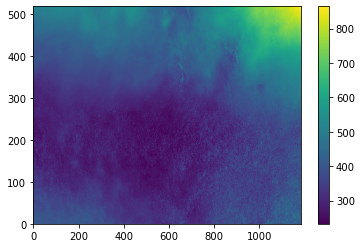

In [48]:
plt.pcolormesh(t600_hist['t_pl'])
plt.colorbar()

In [49]:
u_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u925.nc')
u_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u925.nc')

v_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_v925.nc')
v_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_v925.nc')

In [65]:
u_diff = u_fut['u_pl']-u_hist['u_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
v_diff = v_fut['v_pl']-v_hist['v_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))

mask = (u_diff > 2) | (v_diff > 1)
u_diff = u_diff.where(mask)
v_diff = v_diff.where(mask)

In [85]:
st=10
stt=20
sarrow = 2
xquiv = u_diff.longitude[sarrow::st]
yquiv = u_diff.latitude[sarrow::st]
xquivc = u_diff.longitude[sarrow::stt]
yquivc = u_diff.latitude[sarrow::stt]

uu = (u_diff.values)[sarrow::st, sarrow::st]
uuc = u_hist['u_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1])).values[sarrow::stt, sarrow::stt]
vv = (v_diff.values)[sarrow::st, sarrow::st]
vvc = v_hist['v_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1])).values[sarrow::stt, sarrow::stt]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 45}
qin_clim = {'x' : xquivc, 'y' : yquivc, 'u' : uuc, 'v' : vvc, 'scale' : 45}

In [52]:
tcw_diff = tcw_fut-tcw_hist
t925_diff = t925_fut - t925_hist
q925_diff = q925_fut - q925_hist

In [53]:
q925_fut = q925_fut['q_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))/100/1000
q925_hist = q925_hist['q_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))/100/1000
#tcw_fut = tcw_fut['q_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))/100/1000

tcw_diff = tcw_diff['tcwv'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
tcw_hist = tcw_hist['tcwv'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))

t925_diff = t925_diff['t_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))/100+273.15
t925_hist = t925_hist['t_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))/100+273.15
t925_fut = t925_fut['t_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))/100+273.15

t600_hist = t600_hist['t_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))/100+273.15
t600_fut = t600_fut['t_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))/100+273.15

In [54]:
def draw_map(ax, dat, lat, lon, title='', levels=None, label=None, cmap=None):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), extend='both', levels=levels, cmap=cmap)
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.left_labels = False
    xl.xlines = False
    xl.ylines=False
    xl.bottom_labels = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    ax.set_facecolor('lightgrey')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(label)


In [55]:
cproxy_hist = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_cape_max_*.nc', concat_dim='dummy', combine='nested')['cape'].mean('dummy')
cproxy_fut = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_cape_max_*.nc', concat_dim='dummy', combine='nested')['cape'].mean('dummy')

In [56]:
rh_hist = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_r_max_*.nc', concat_dim='dummy', combine='nested')['r'].mean('dummy')
rh_fut = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_r_max_*.nc', concat_dim='dummy', combine='nested')['r'].mean('dummy')

In [57]:
cproxy_hist_mean = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_cape_mean_*.nc', concat_dim='dummy', combine='nested')['cape'].mean('dummy')
cproxy_fut_mean = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_cape_mean_*.nc', concat_dim='dummy', combine='nested')['cape'].mean('dummy')

In [58]:
rh_hist_mean = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_r_mean_*.nc', concat_dim='dummy', combine='nested')['r'].mean('dummy')
rh_fut_mean = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_r_mean_*.nc', concat_dim='dummy', combine='nested')['r'].mean('dummy')

In [124]:
thetae_hist = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_thetae_max_*.nc', concat_dim='dummy', combine='nested')['thetae'].mean('dummy')
thetae_fut = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_thetae_max_*.nc', concat_dim='dummy', combine='nested')['thetae'].mean('dummy')

In [125]:
thetae_hist_mean = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_thetae_mean_*.nc', concat_dim='dummy', combine='nested')['thetae'].mean('dummy')
thetae_fut_mean = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_thetae_mean_*.nc', concat_dim='dummy', combine='nested')['thetae'].mean('dummy')

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


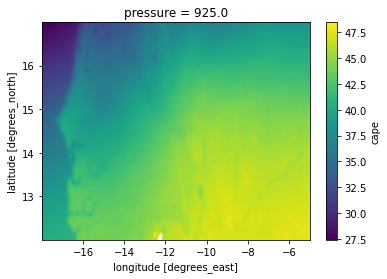

In [59]:
cproxy_hist_mean.plot()

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


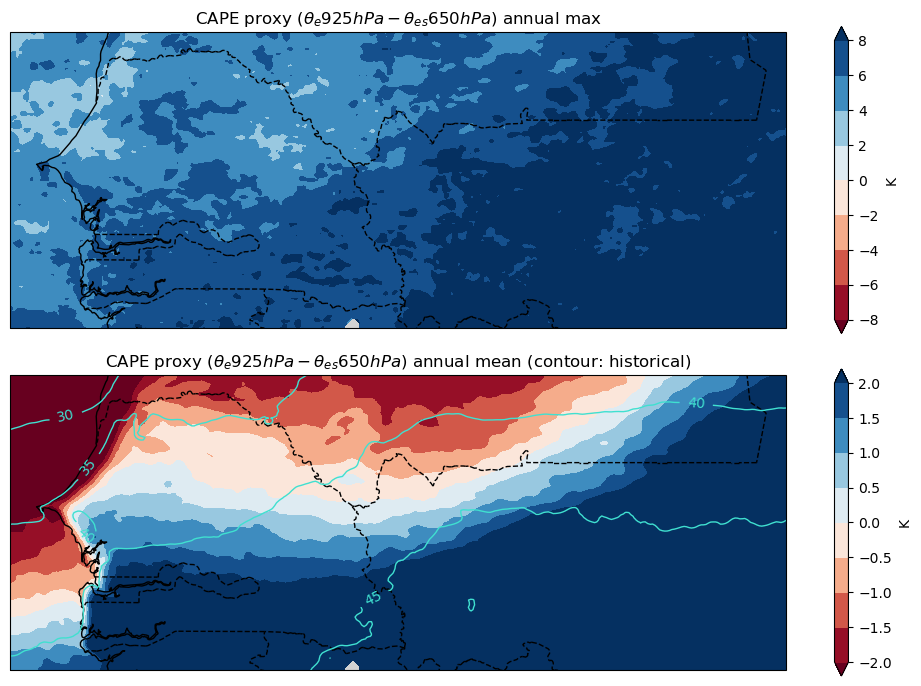

In [60]:
f = plt.figure(figsize=(10,7), dpi=100)   #13,7.5

ax2 = f.add_subplot(211, projection=ccrs.PlateCarree())
draw_map(ax2, cproxy_fut-cproxy_hist, cproxy_fut.latitude, cproxy_fut.longitude, title=r'CAPE proxy ($\theta_{e}925hPa - \theta_{es}650hPa$) annual max', levels=np.arange(-8,8.1,2), label=r'K', cmap='RdBu')
# cs = ax2.contour(cproxy_hist.longitude, cproxy_hist.latitude, cproxy_hist, colors='purple', linewidths=1, levels=[48,52,56,60], transform=ccrs.PlateCarree())
# ax2.clabel(cs, inline=True, fontsize=10, fmt='%1.0f')
               
ax = f.add_subplot(212, projection=ccrs.PlateCarree())
draw_map(ax, cproxy_fut_mean-cproxy_hist_mean, cproxy_fut.latitude, cproxy_fut.longitude, title=r'CAPE proxy ($\theta_{e}925hPa - \theta_{es}650hPa$) annual mean (contour: historical)', levels=np.arange(-2,2.1,0.5), label=r'K', cmap='RdBu')
cs = ax.contour(cproxy_hist_mean.longitude, cproxy_hist.latitude, cproxy_hist_mean, colors='turquoise', linewidths=1, levels=[30,35,40,45], transform=ccrs.PlateCarree())
ax.clabel(cs, inline=True, fontsize=10, fmt='%1.0f')

plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_CAPEproxy_Senegal.jpg')

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/m

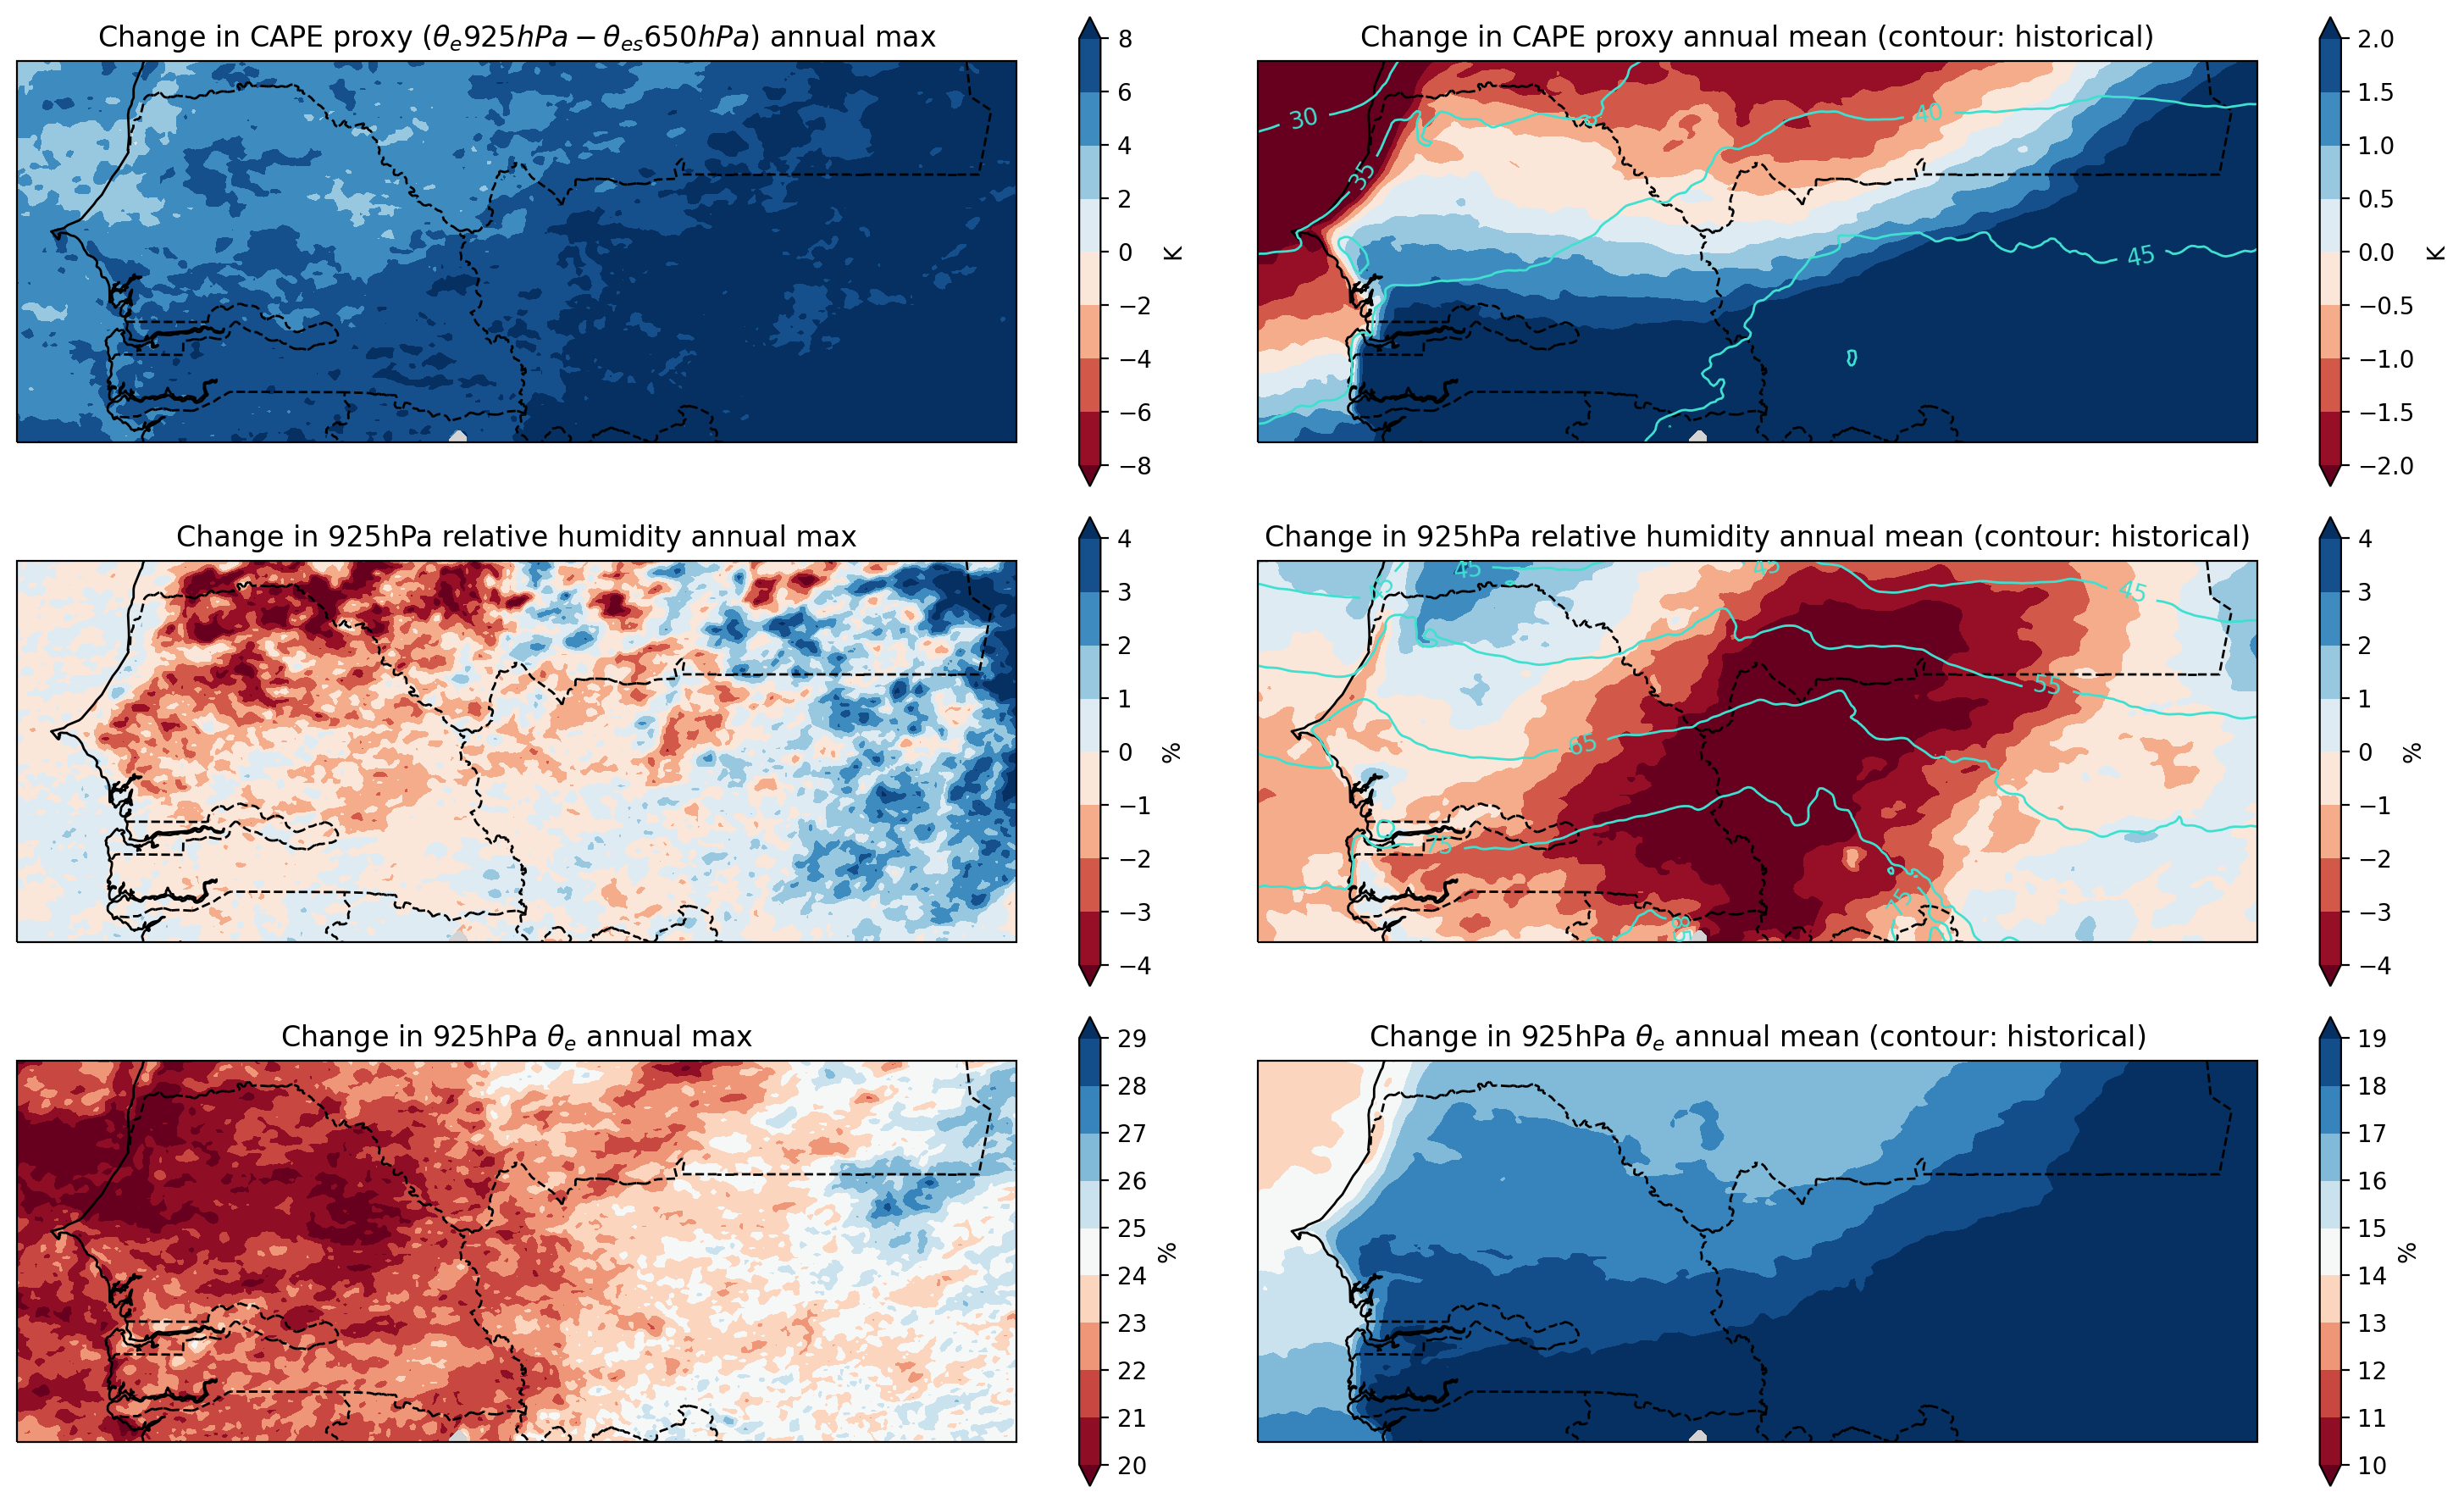

In [129]:
f = plt.figure(figsize=(15,9), dpi=200)   #13,7.5

ax2 = f.add_subplot(321, projection=ccrs.PlateCarree())
draw_map(ax2, cproxy_fut-cproxy_hist, cproxy_fut.latitude, cproxy_fut.longitude, title=r'Change in CAPE proxy ($\theta_{e}925hPa - \theta_{es}650hPa$) annual max', levels=np.arange(-8,8.1,2), label=r'K', cmap='RdBu')
# cs = ax2.contour(cproxy_hist.longitude, cproxy_hist.latitude, cproxy_hist, colors='purple', linewidths=1, levels=[48,52,56,60], transform=ccrs.PlateCarree())
# ax2.clabel(cs, inline=True, fontsize=10, fmt='%1.0f')
               
ax = f.add_subplot(322, projection=ccrs.PlateCarree())
draw_map(ax, cproxy_fut_mean-cproxy_hist_mean, cproxy_fut.latitude, cproxy_fut.longitude, title=r'Change in CAPE proxy annual mean (contour: historical)', levels=np.arange(-2,2.1,0.5), label=r'K', cmap='RdBu')
cs = ax.contour(cproxy_hist_mean.longitude, cproxy_hist.latitude, cproxy_hist_mean, colors='turquoise', linewidths=1, levels=[30,35,40,45], transform=ccrs.PlateCarree())
ax.clabel(cs, inline=True, fontsize=10, fmt='%1.0f')

ax1 = f.add_subplot(323, projection=ccrs.PlateCarree())
draw_map(ax1, (rh_fut-rh_hist)*100, cproxy_fut.latitude, cproxy_fut.longitude, title='Change in 925hPa relative humidity annual max', levels=np.arange(-4,5,1), label=r'%', cmap='RdBu')

ax1 = f.add_subplot(324, projection=ccrs.PlateCarree())
draw_map(ax1, (rh_fut_mean-rh_hist_mean)*100, cproxy_fut.latitude, cproxy_fut.longitude, title='Change in 925hPa relative humidity annual mean (contour: historical)', levels=np.arange(-4,5,1), label=r'%', cmap='RdBu')
cs = ax1.contour(cproxy_hist_mean.longitude, cproxy_hist.latitude, rh_hist_mean*100, colors='turquoise', linewidths=1,  levels=[45,55,65,75,85],transform=ccrs.PlateCarree())
ax.clabel(cs, inline=True, fontsize=10, fmt='%1.0f')

ax1 = f.add_subplot(325, projection=ccrs.PlateCarree())
draw_map(ax1, (thetae_fut-thetae_hist), cproxy_fut.latitude, cproxy_fut.longitude, title=r'Change in 925hPa $\theta_e$ annual max', levels=np.arange(20,30,1), label=r'%', cmap='RdBu')

ax1 = f.add_subplot(326, projection=ccrs.PlateCarree())
draw_map(ax1, (thetae_fut_mean-thetae_hist_mean), cproxy_fut.latitude, cproxy_fut.longitude, title=r'Change in 925hPa $\theta_e$ annual mean (contour: historical)', levels=np.arange(10,20,1), label=r'%', cmap='RdBu')
cs = ax1.contour(cproxy_hist_mean.longitude, cproxy_hist.latitude, thetae_hist_mean, colors='turquoise', linewidths=1,  levels=[45,55,65,75,85],transform=ccrs.PlateCarree())
ax.clabel(cs, inline=True, fontsize=10, fmt='%1.0f')

plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_CAPEproxy_RH_change_Senegal.jpg')

In [62]:
(((tcw_diff/tcw_hist*100)).values[1::,1::])/(t925_fut-t925_hist).values

array([[17.08077559, 14.86307242, 13.50880736, ...,  6.97109757,
         7.25755522,  6.84156037],
       [14.72569632, 14.78871935, 14.5534531 , ...,  6.544238  ,
         6.82289733,  6.49264715],
       [14.763655  , 14.26114631, 14.36798638, ...,  6.73289486,
         6.38174686,  5.91136327],
       ...,
       [ 4.77900157,  4.39988406,  4.22106552, ...,  8.38466156,
         8.50807763,  8.68410888],
       [ 4.64009858,  4.31187818,  4.16238747, ...,  8.60753011,
         8.6613051 ,  8.71246503],
       [ 4.60541998,  4.40620228,  4.19230497, ...,  8.35897643,
         8.20427481,  8.07737894]])

In [63]:
(t925_fut-t925_hist)

<xarray.DataArray 't_pl' (latitude: 308, longitude: 444)>
array([[5.03111111, 4.93777778, 4.88666667, ..., 4.51666667, 4.50666667,
        4.50444444],
       [4.93666667, 4.94888889, 4.88444444, ..., 4.50555556, 4.50111111,
        4.49333333],
       [4.97111111, 4.95      , 4.84444444, ..., 4.47777778, 4.48111111,
        4.49333333],
       ...,
       [5.81555556, 5.83555556, 5.84777778, ..., 5.94      , 5.92222222,
        5.94      ],
       [5.79111111, 5.82777778, 5.86111111, ..., 5.86444444, 5.86888889,
        5.90555556],
       [5.83222222, 5.88888889, 5.94222222, ..., 5.89      , 5.89111111,
        5.93      ]])
Coordinates:
    pressure                 float32 925.0
  * latitude                 (latitude) float32 4.533001 4.5735016 ... 16.966503
  * longitude                (longitude) float32 -17.979492 ... -0.037994385
    forecast_reference_time  object ...

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/pyt

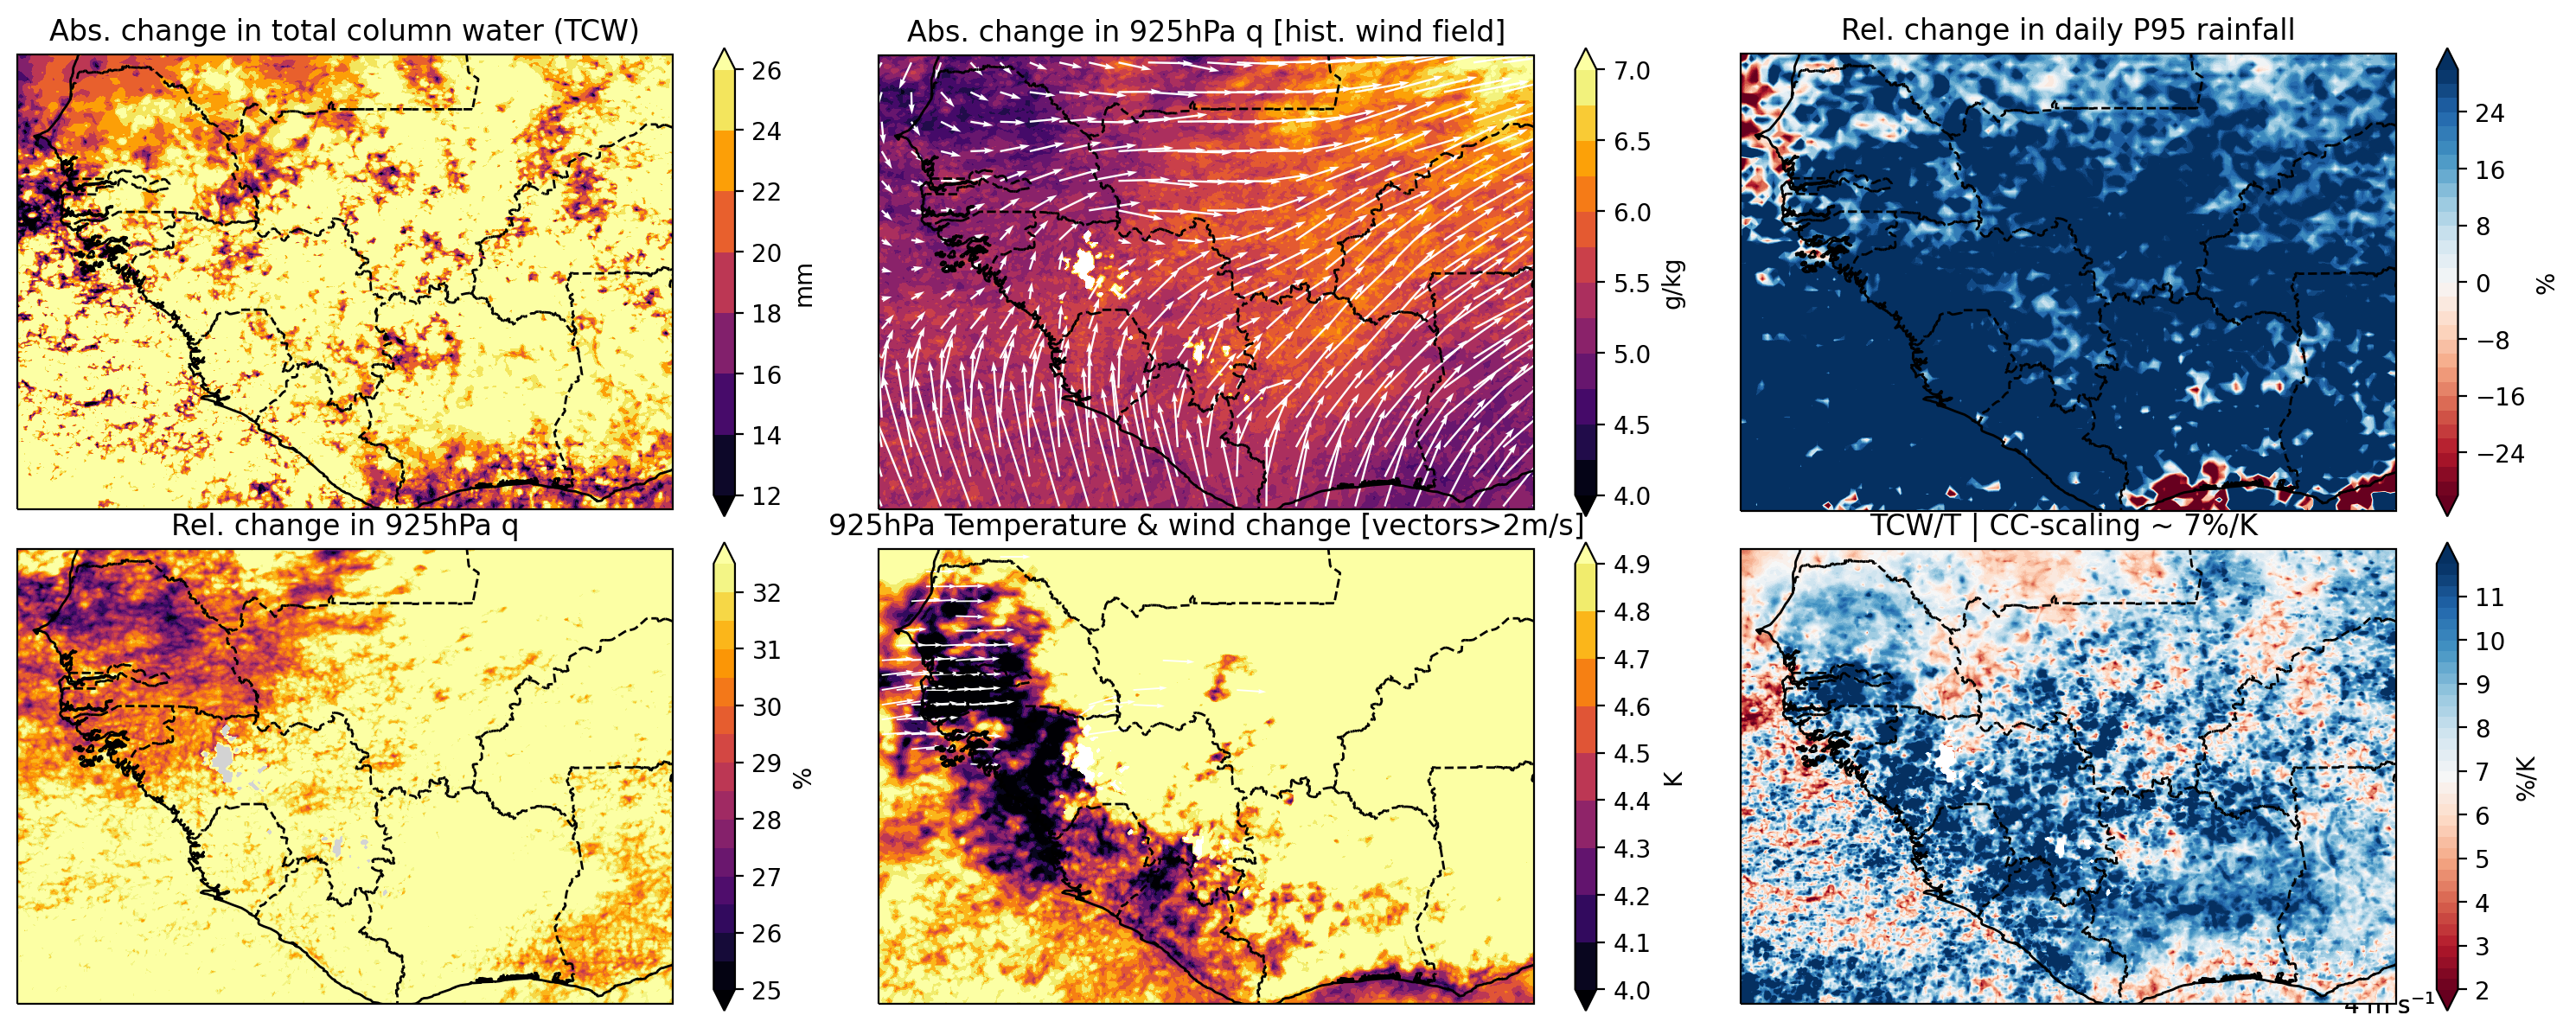

In [130]:
f = plt.figure(figsize=(15,6), dpi=200)   #13,7.5

ax2 = f.add_subplot(231, projection=ccrs.PlateCarree())
draw_map(ax2, tcw_diff, tcw_diff.latitude, tcw_diff.longitude, title='Abs. change in total column water (TCW)', levels=np.arange(12,26.1,2), label=r'mm', cmap='inferno')
#plt.pcolormesh(ttcw_diff.values)

        

               
ax = f.add_subplot(232, projection=ccrs.PlateCarree())
draw_map_wind(ax, (q925_fut-q925_hist)*1000, q925_fut.longitude, q925_fut.latitude, quiver=qin_clim, vc='white',title='Abs. change in 925hPa q [hist. wind field]', levels=np.arange(4,7.1,0.25), cbar_label='g/kg', cmap='inferno', extend='both')

# ax1 = f.add_subplot(223, projection=ccrs.PlateCarree())
# draw_map(ax1, (rf-rh)*100, t_diff.latitude, t_diff.longitude, title='Change in 925hPa relative humidity', levels=[-4,-3,-2,-1,1,2,3,4], label=r'%', cmap='RdBu')
               


# ax1 = f.add_subplot(233, projection=ccrs.PlateCarree())
# testrain = ((fm-hm)/hm*100).sel(latitude=slice(box[2],box[3]), longitude=slice(box[0], box[1]))
# draw_map(ax1, testrain, testrain.latitude, testrain.longitude, title='Rel. change in daily P95 rainfall', levels=np.arange(-70,71,10), label=r'%', cmap='RdBu')

ax1 = f.add_subplot(233, projection=ccrs.PlateCarree())
testrain = ((fm-hm)).sel(latitude=slice(box[2],box[3]), longitude=slice(box[0], box[1]))
draw_map(ax1, testrain, testrain.latitude, testrain.longitude, title='Rel. change in daily P95 rainfall', levels=np.arange(-30,31,2), label=r'%', cmap='RdBu')

# ax1 = f.add_subplot(224, projection=ccrs.PlateCarree())
# draw_map(ax1, (qf-qh)*1000/(qh*1000)*100, t_diff.latitude, t_diff.longitude, title='Relative change in 925hPa specific humidity', levels=np.arange(25,35,1), label=r'%', cmap='RdBu')

ax1 = f.add_subplot(234, projection=ccrs.PlateCarree())
draw_map(ax1, (q925_fut-q925_hist)*1000/(q925_hist*1000)*100, t925_hist.latitude, t925_hist.longitude, title='Rel. change in 925hPa q', levels=np.arange(25,33,0.5), label=r'%', cmap='inferno')
#draw_map(ax1, (qf)*1000, t_diff.latitude, t_diff.longitude, title='Rel. change in 925hPa specific humidity', levels=np.arange(10,20,0.5), label=r'g/kg', cmap='RdBu')
plt.contour(t925_hist.longitude, t925_hist.latitude, (q925_fut)*1000,levels=[15,16,17,18], colors='turquoise', linewidths=1, transform=ccrs.PlateCarree())

ax1 = f.add_subplot(235, projection=ccrs.PlateCarree())


draw_map_wind(ax1, (t925_fut-t925_hist), t925_hist.longitude, t925_hist.latitude, title='925hPa Temperature & wind change [vectors>2m/s]',  quiver=qin, cbar_label='K', cmap='inferno', levels=np.arange(4,5, 0.1), extend='both')

ax1 = f.add_subplot(236, projection=ccrs.PlateCarree())
draw_map_wind(ax1, (((tcw_diff/tcw_hist*100)).values[1::,1::])/(t925_fut-t925_hist).values, t925_hist.longitude, t925_hist.latitude, title='TCW/T | CC-scaling ~ 7%/K ', cbar_label='%/K', cmap='RdBu', levels=np.arange(2,12, 0.25), extend='both')

#[1::,:]
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_TCW_RH_change_WADomain_max.jpg')

TypeError: draw_map() got an unexpected keyword argument 'quiver'

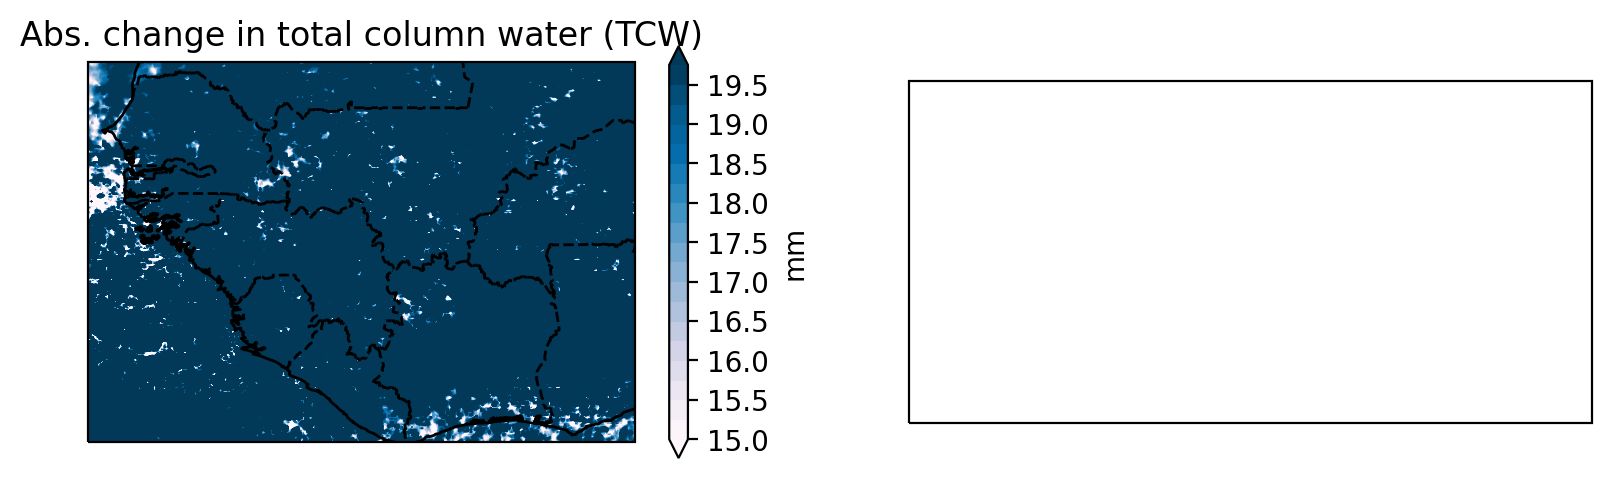

In [118]:
def draw_map(ax, dat, lat, lon, title='', levels=None, label=None, cmap=None):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), extend='both', levels=levels, cmap=cmap)
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.left_labels = False
    xl.xlines = False
    xl.ylines=False
    xl.bottom_labels = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    ax.set_facecolor('lightgrey')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(label)


f = plt.figure(figsize=(15,6), dpi=200)   #13,7.5

ax2 = f.add_subplot(231, projection=ccrs.PlateCarree())
draw_map(ax2, tcw_diff, tcw_diff.latitude, tcw_diff.longitude, title='Abs. change in total column water (TCW)', levels=np.arange(15,20,0.25), label=r'mm', cmap='PuBu')
#plt.pcolormesh(ttcw_diff.values)

               
ax = f.add_subplot(232, projection=ccrs.PlateCarree())
draw_map(ax, tcw_diff/tcw_hist*100, tcw_diff.latitude, tcw_diff.longitude, title='Relative change in TCW',  quiver=qin, levels=np.arange(35,42,0.25), label=r'%', cmap='RdBu')

# ax1 = f.add_subplot(223, projection=ccrs.PlateCarree())
# draw_map(ax1, (rf-rh)*100, t_diff.latitude, t_diff.longitude, title='Change in 925hPa relative humidity', levels=[-4,-3,-2,-1,1,2,3,4], label=r'%', cmap='RdBu')
               


# ax1 = f.add_subplot(233, projection=ccrs.PlateCarree())
# testrain = ((fm-hm)/hm*100).sel(latitude=slice(box[2],box[3]), longitude=slice(box[0], box[1]))
# draw_map(ax1, testrain, testrain.latitude, testrain.longitude, title='Rel. change in daily P95 rainfall', levels=np.arange(-70,71,10), label=r'%', cmap='RdBu')

ax1 = f.add_subplot(233, projection=ccrs.PlateCarree())
testrain = ((fm-hm)).sel(latitude=slice(box[2],box[3]), longitude=slice(box[0], box[1]))
draw_map(ax1, testrain, testrain.latitude, testrain.longitude, title='Rel. change in daily P95 rainfall', levels=np.arange(-30,30,2), label=r'%', cmap='RdBu')

# ax1 = f.add_subplot(224, projection=ccrs.PlateCarree())
# draw_map(ax1, (qf-qh)*1000/(qh*1000)*100, t_diff.latitude, t_diff.longitude, title='Relative change in 925hPa specific humidity', levels=np.arange(25,35,1), label=r'%', cmap='RdBu')

ax1 = f.add_subplot(234, projection=ccrs.PlateCarree())
draw_map(ax1, (qf-qh)*1000/(qh*1000)*100, t925_diff.latitude, t925_diff.longitude, title='Rel. change in 925hPa q | contours: historical', levels=np.arange(25,33,0.5), label=r'%', cmap='RdBu')
#draw_map(ax1, (qf)*1000, t_diff.latitude, t_diff.longitude, title='Rel. change in 925hPa specific humidity', levels=np.arange(10,20,0.5), label=r'g/kg', cmap='RdBu')
plt.contour(t925_diff.longitude, t925_diff.latitude, (qf)*1000,levels=[15,16,17,18], colors='turquoise', linewidths=1, transform=ccrs.PlateCarree())

ax1 = f.add_subplot(235, projection=ccrs.PlateCarree())


draw_map_wind(ax1, (tf-th), t925_diff.longitude, t925_diff.latitude, title='Temperature & [wind change>2m/s]',  quiver=qin, cbar_label='K', cmap='inferno_r', levels=np.arange(4,5, 0.1), extend='both')

ax1 = f.add_subplot(236, projection=ccrs.PlateCarree())
draw_map_wind(ax1, ((tcw_diff/tcw_hist*100))[1::,1::]/(tf-th), t925_diff.longitude, t925_diff.latitude, title='TCW/T | CC-scaling ~ 7%/K', cbar_label='%/K', cmap='RdBu', levels=np.arange(4,10, 0.25), extend='both')

#[1::,:]
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_TCW_RH_change_WADomain.jpg')

In [88]:
tcw_diff

<xarray.DataArray 'tcwv' (latitude: 309, longitude: 445)>
array([[40.689777, 39.738716, 38.564564, ..., 20.58236 , 20.935768,
        20.176216],
       [47.731445, 51.562283, 44.44054 , ..., 19.436634, 20.042534,
        19.174152],
       [43.778324, 43.86133 , 44.27604 , ..., 18.514648, 19.138454,
        18.393124],
       ...,
       [17.363602, 16.497936, 15.48904 , ..., 24.776798, 25.009007,
        25.64952 ],
       [17.038952, 16.016605, 15.178387, ..., 25.005642, 25.09494 ,
        25.460396],
       [16.767467, 15.969505, 15.532009, ..., 24.582138, 24.248695,
        24.112625]], dtype=float32)
Coordinates:
  * latitude                 (latitude) float32 4.5127525 ... 16.986752
  * longitude                (longitude) float32 -17.999756 ... -0.01776123
    forecast_reference_time  object ...

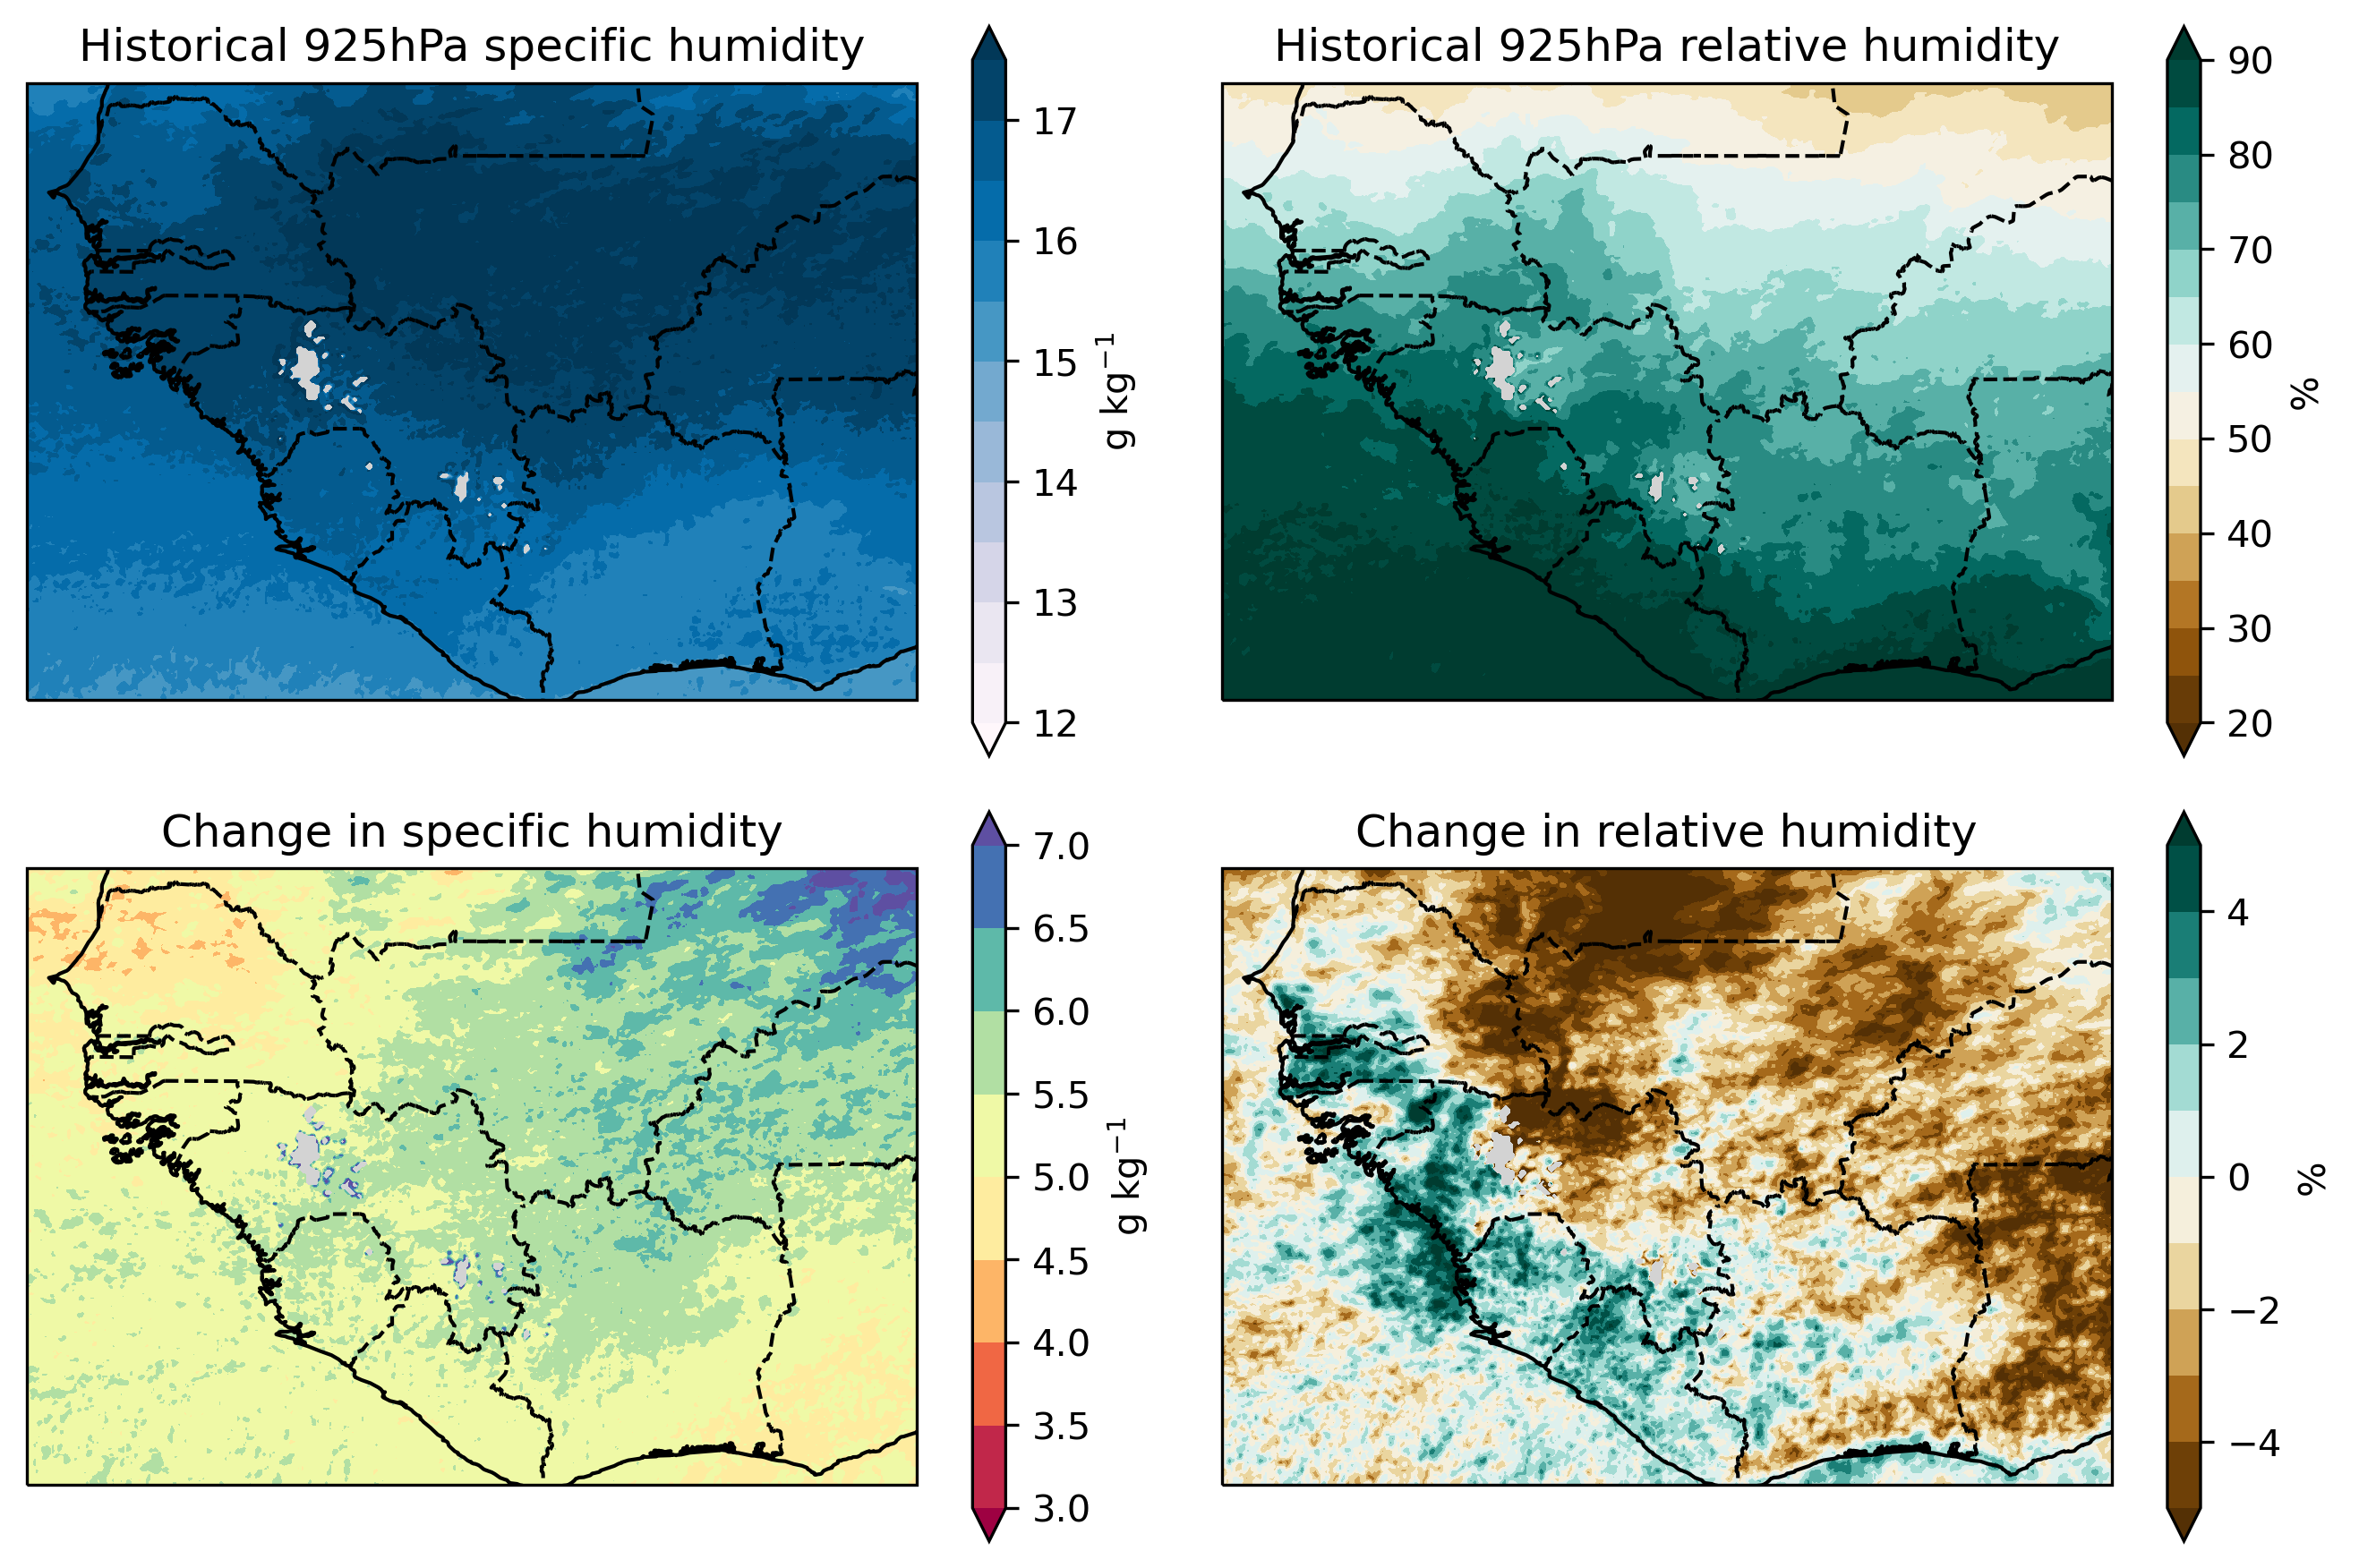

In [91]:
f = plt.figure(figsize=(9,6), dpi=300)

ax2 = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax2, qh*1000, q925_hist.latitude, q925_hist.longitude, title='Historical 925hPa specific humidity', levels=np.arange(12,18,0.5), label=r'g kg$^{-1}$', cmap='PuBu')
ax3 = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax3, rh*100, q925_hist.latitude, q925_hist.longitude, title='Historical 925hPa relative humidity', levels=np.arange(20,91,5), label=r'%', cmap='BrBG')


ax = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax, (qf-qh)*1000, q925_hist.latitude, q925_hist.longitude, title='Change in specific humidity', levels=np.arange(3,7.1,0.5), label=r'g kg$^{-1}$', cmap='Spectral')
ax1 = f.add_subplot(224, projection=ccrs.PlateCarree())
draw_map(ax1, rh_diff*100, q925_hist.latitude, q925_hist.longitude, title='Change in relative humidity', levels=np.arange(-5,5.1,1), label=r'%', cmap='BrBG')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_q_rh_change.jpg')

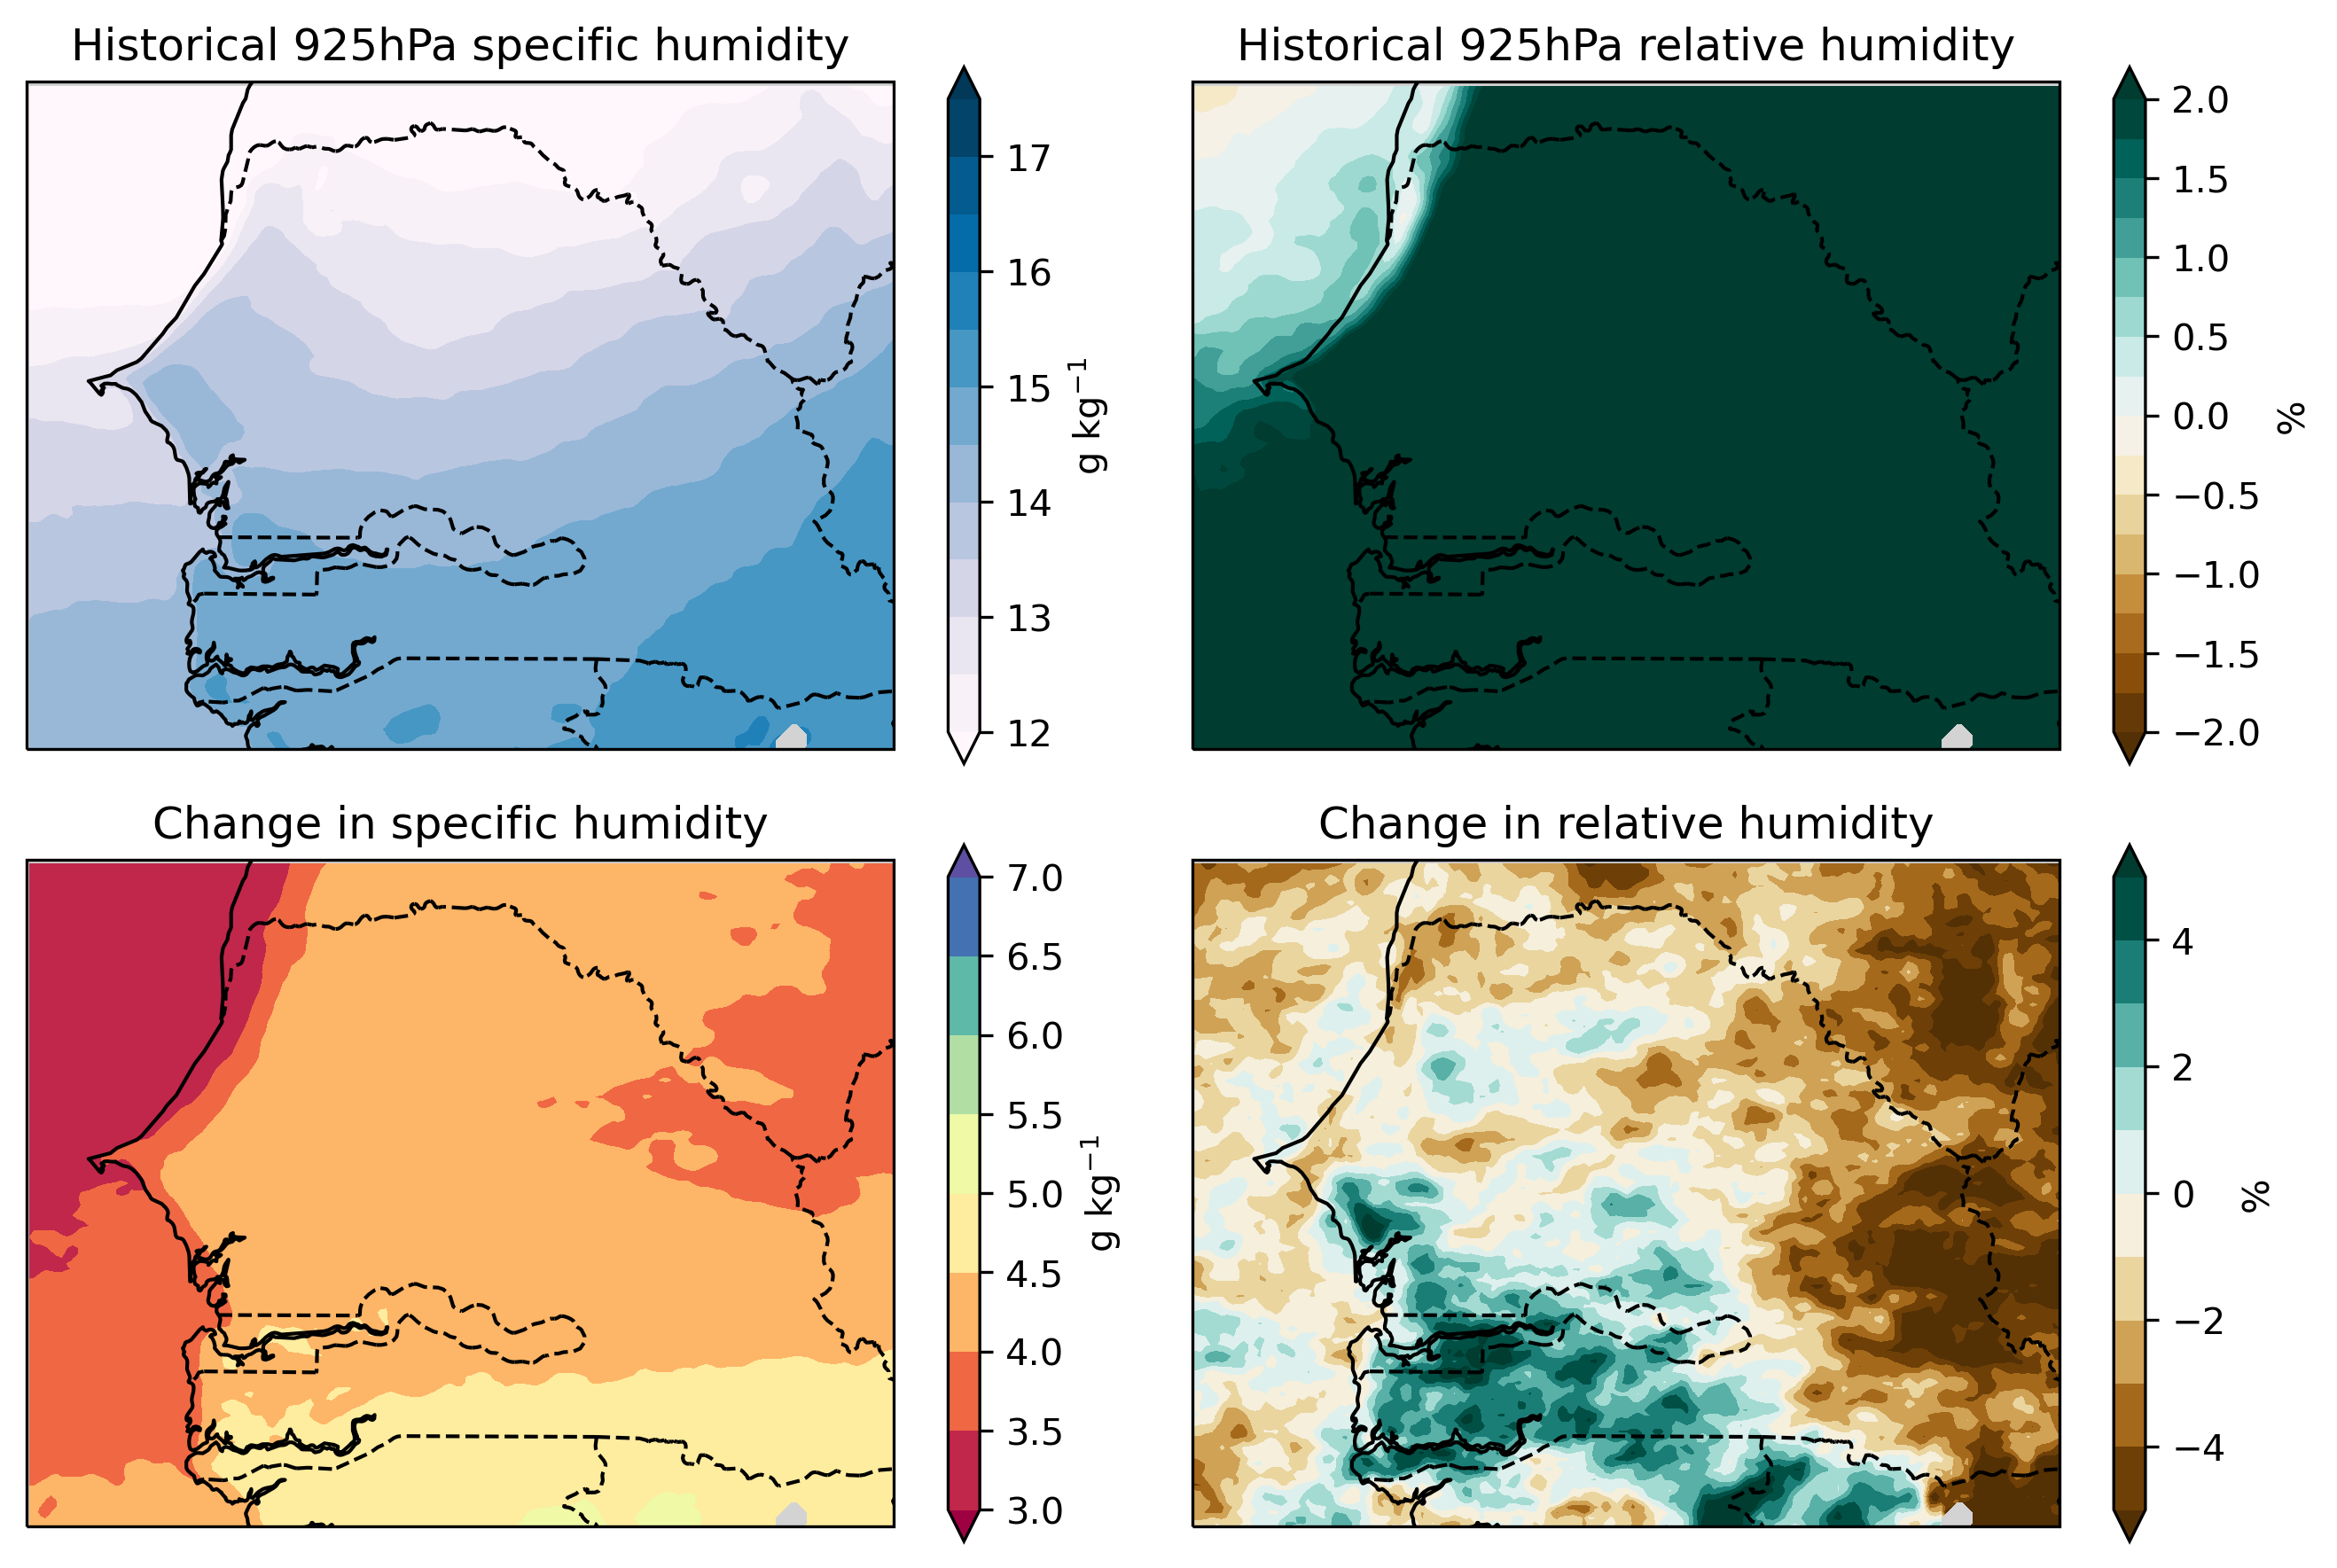

In [128]:
f = plt.figure(figsize=(9,6), dpi=300)

ax2 = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax2, qh*1000, q925_hist.latitude, q925_hist.longitude, title='Historical 925hPa specific humidity', levels=np.arange(12,18,0.5), label=r'g kg$^{-1}$', cmap='PuBu')
ax2.set_xlim(-18,-11.5)
ax2.set_ylim(12,17)

ax3 = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax3, cape_fut-cape_hist, q925_hist.latitude, q925_hist.longitude, title='Historical 925hPa relative humidity', levels=np.arange(-2,2.01,0.25), label=r'%', cmap='BrBG')
ax3.set_xlim(-18,-11.5)
ax3.set_ylim(12,17)

ax = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax, (qf-qh)*1000, q925_hist.latitude, q925_hist.longitude, title='Change in specific humidity', levels=np.arange(3,7.1,0.5), label=r'g kg$^{-1}$', cmap='Spectral')
ax.set_xlim(-18,-11.5)
ax.set_ylim(12,17)

ax1 = f.add_subplot(224, projection=ccrs.PlateCarree())
draw_map(ax1, rh_diff*100, q925_hist.latitude, q925_hist.longitude, title='Change in relative humidity', levels=np.arange(-5,5.1,1), label=r'%', cmap='BrBG')
ax1.set_xlim(-18,-11.5)
ax1.set_ylim(12,17)

plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_q_rh_change_senegal.jpg')

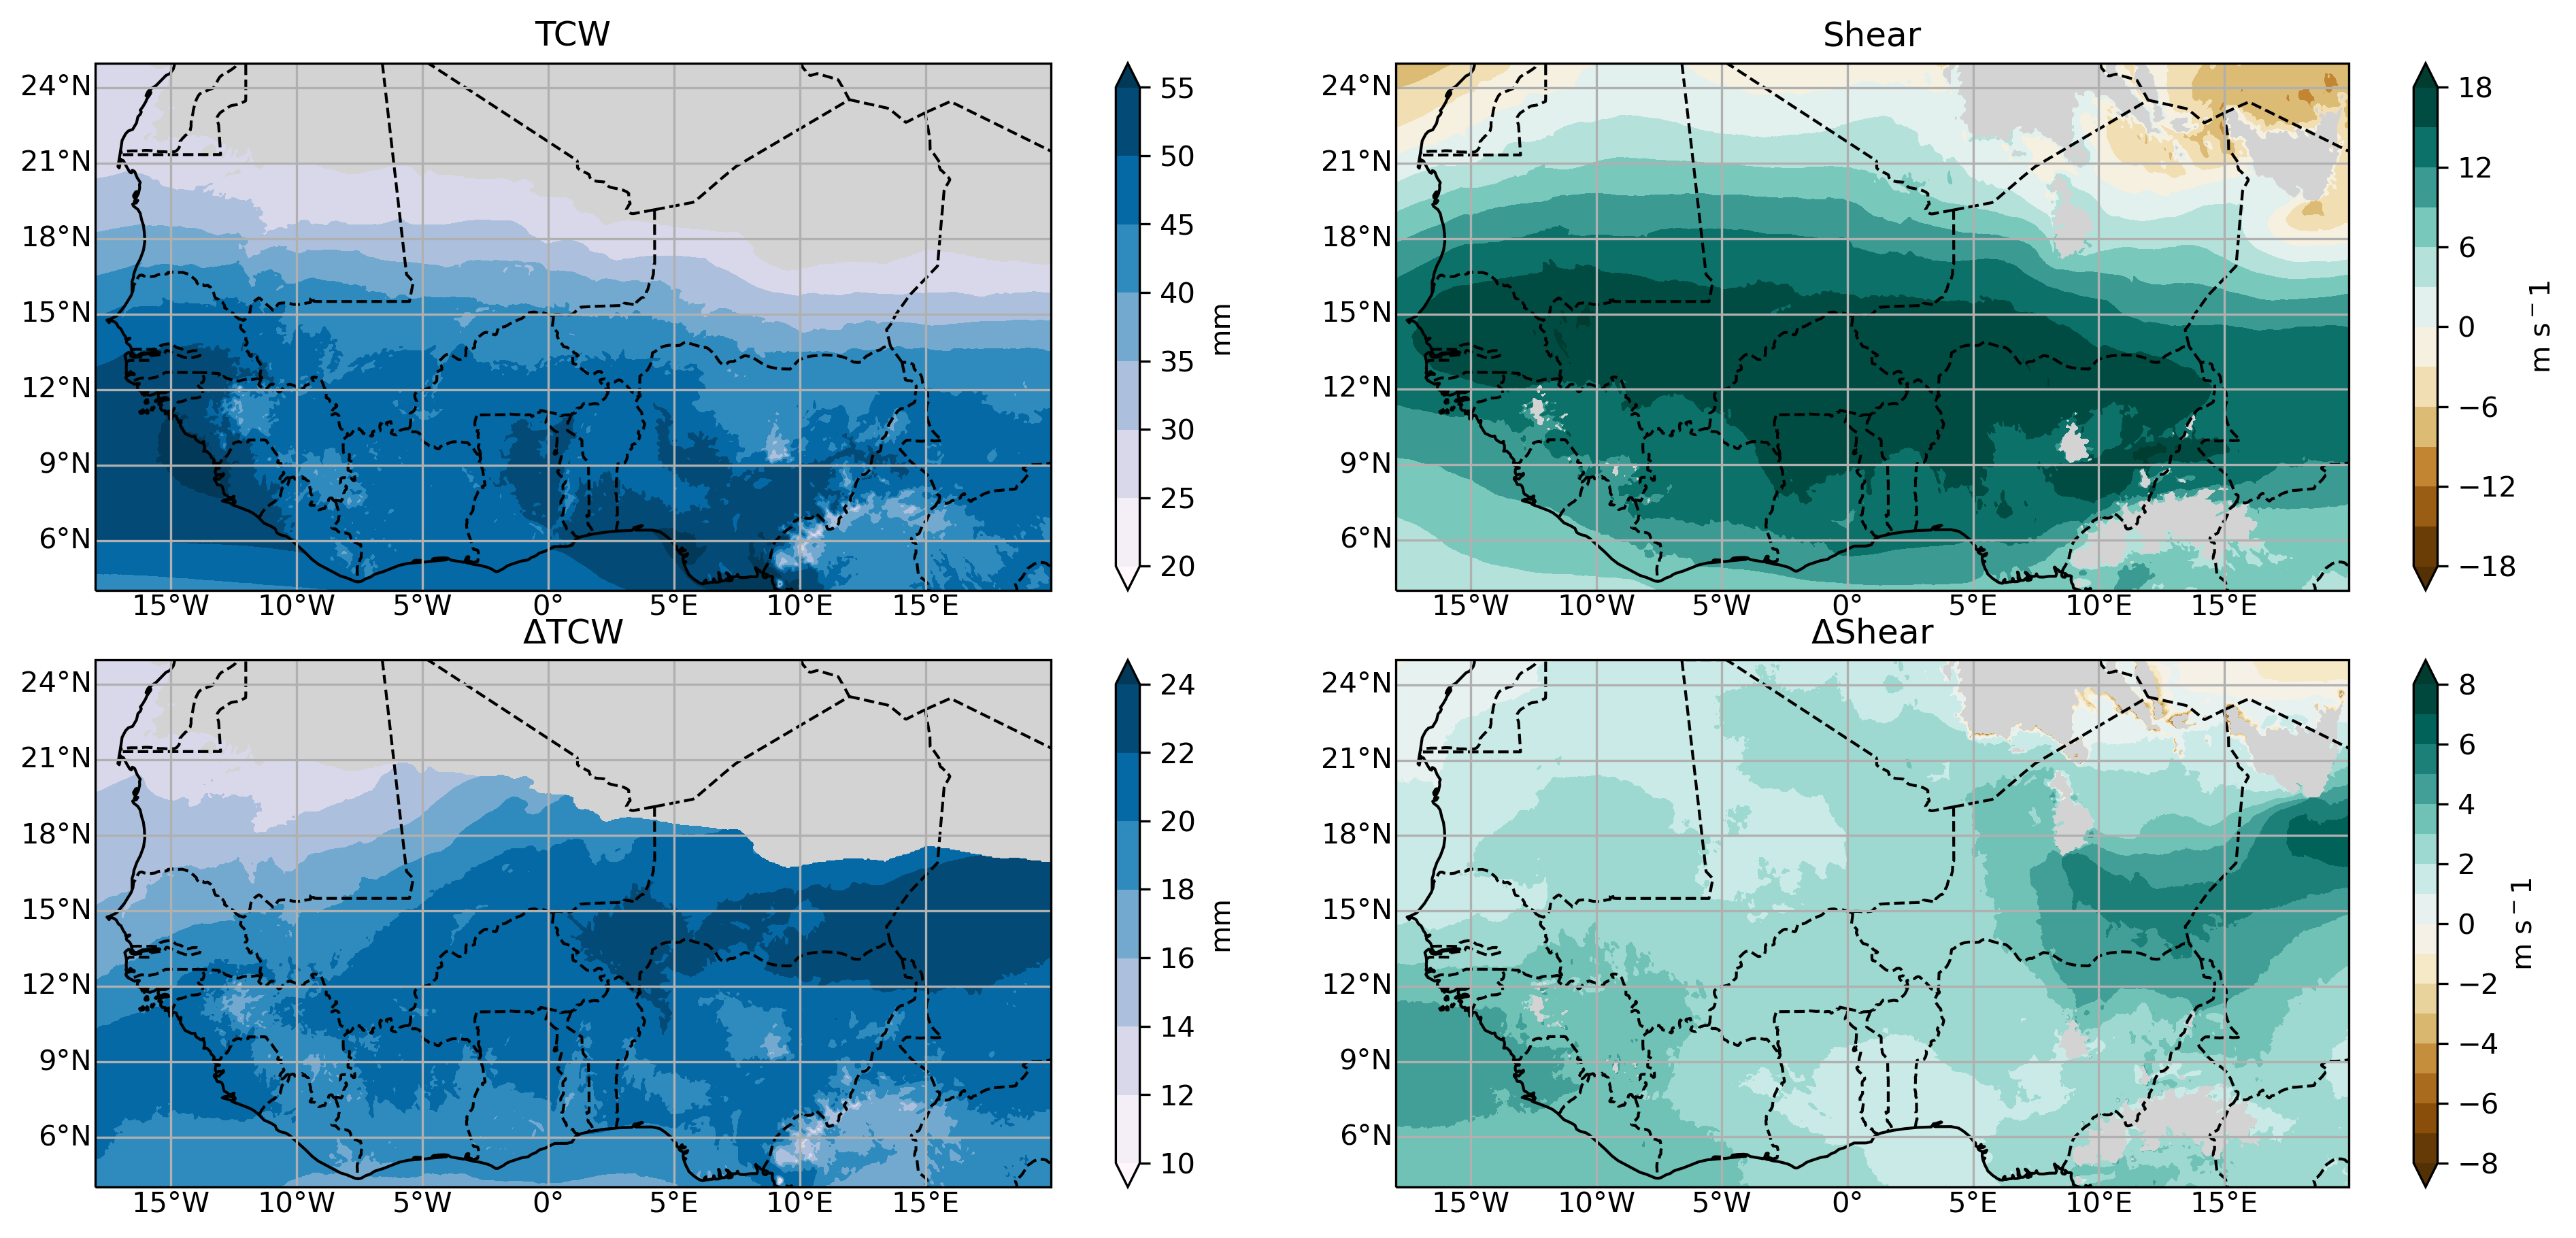

In [21]:
f = plt.figure(figsize=(13,6), dpi=300)

ax2 = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax2, tcw_hist.where(tcw_hist>25), tcw_diff.latitude, tcw_diff.longitude, title='TCW', levels=np.arange(20,56,5), label=r'mm', cmap='PuBu')
ax3 = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax3, shear_hist, shear_diff.latitude, shear_diff.longitude, title='Shear', levels=np.arange(-18,19,3), label=r'm s$^-1$', cmap='BrBG')


ax = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax, tcw_diff.where(tcw_hist>25), tcw_diff.latitude, tcw_diff.longitude, title='$\Delta$TCW', levels=np.arange(10,25,2), label=r'mm', cmap='PuBu')
ax1 = f.add_subplot(224, projection=ccrs.PlateCarree())
draw_map(ax1, shear_diff, shear_diff.latitude, shear_diff.longitude, title='$\Delta$Shear', levels=np.arange(-8,9,1), label=r'm s$^-1$', cmap='BrBG')
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_TCWABS_SHEAR_baseline.jpg')

In [19]:
tcw_diff.where(tcw_hist['tcwv']>20).shape

(518, 939)

In [22]:
shearfac = 0.71 # monthly: 0.55
tcwvfac = 3.12 # relative change
tcabsfac = 1.22 # absolute change
tcabserrlow = (tcabsfac-2*0.1)
tcabserrhigh = (tcabsfac+2*0.1)
mmPerPercent = tcabsfac/tcwvfac

# tcwvperr = 0.15 #%
# sherr = 0.051 # mm / shear
# shperr = sherr * mmPerPercent

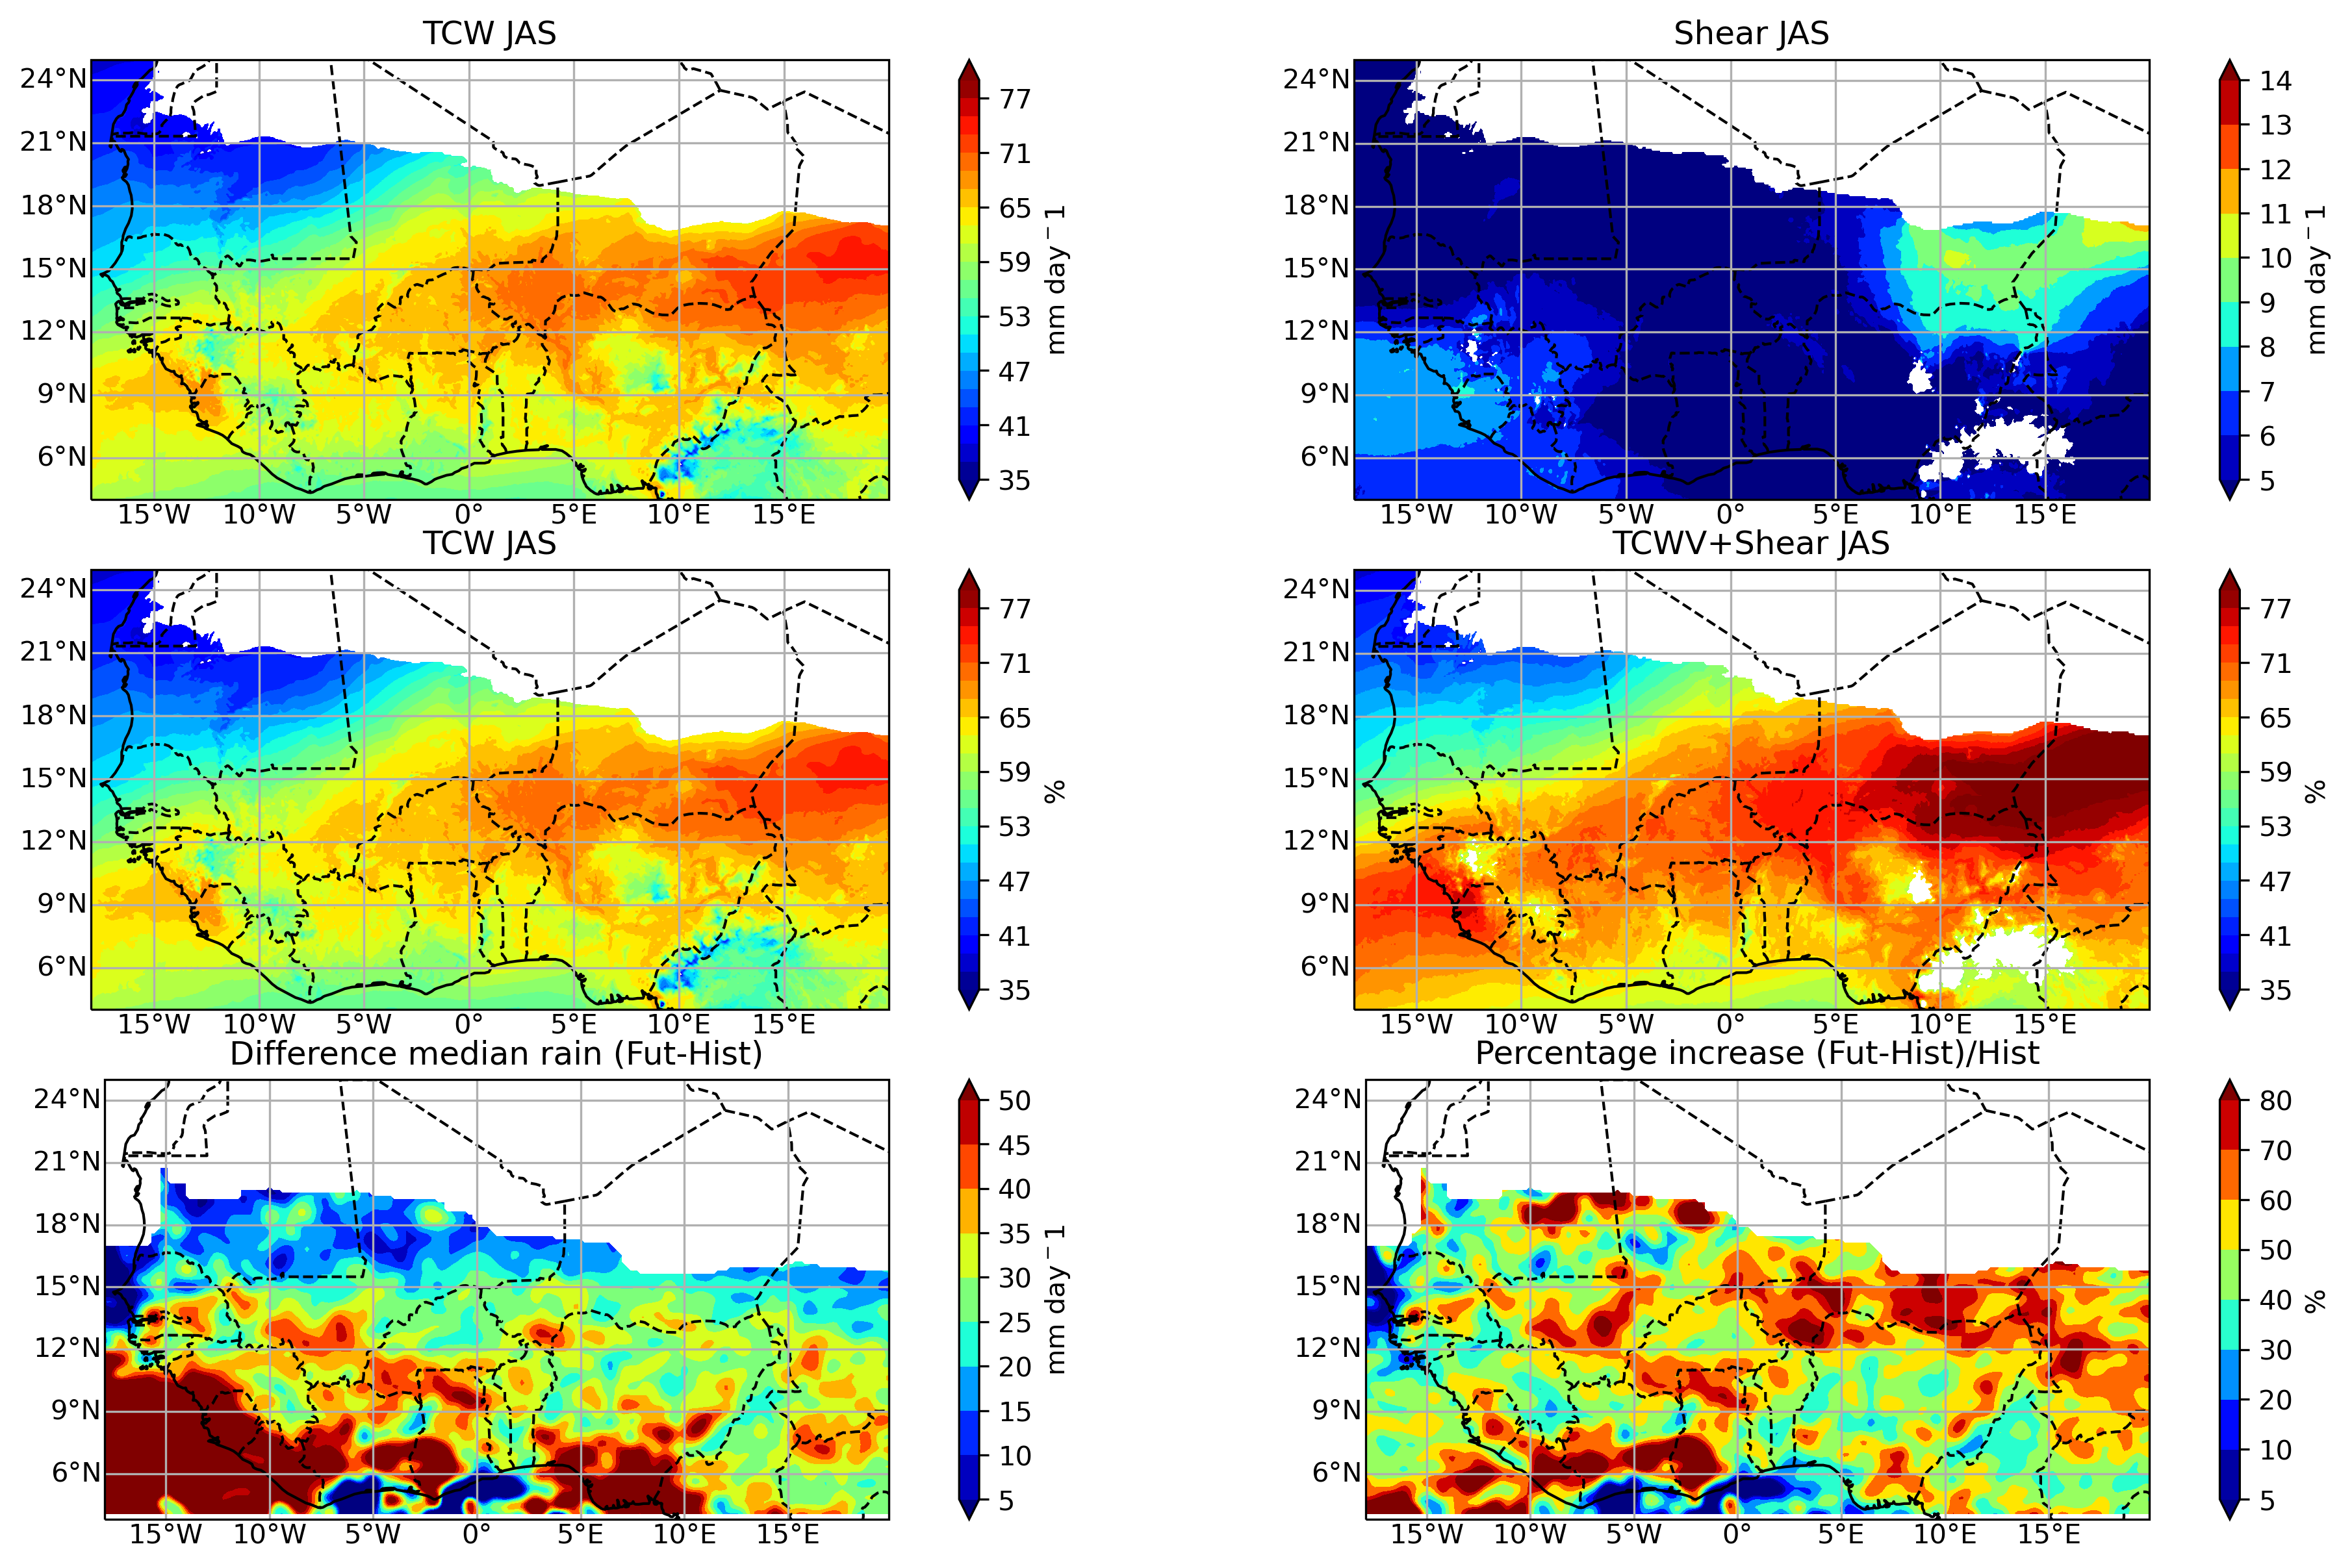

In [42]:
from scipy import ndimage
f = plt.figure(figsize=(14,8), dpi=300)
tthresh = 24.5   # 0.5th centile
thist_on_precip = fm.salem.lookup_transform(tcw_hist['tcwv'])
thist_on_shear = shear_diff.salem.transform(tcw_hist['tcwv'])
tdiff_on_shear = shear_diff.salem.transform(tcw_diff)

#ndimage.gaussian_filter(((dic2['lsta0']) / (dic2['cnt0'])), 2, mode='nearest')

ax = f.add_subplot(321, projection=ccrs.PlateCarree())
draw_map(ax, tcw_diff.where(tcw_hist['tcwv']>tthresh)*tcabsfac/mmPerPercent, tcw_diff.latitude, tcw_diff.longitude, title='TCW JAS', levels=np.arange(35,81,2), label=r'mm day$^-1$')
ax1 = f.add_subplot(322, projection=ccrs.PlateCarree())
draw_map(ax1, shear_diff.where(thist_on_shear>tthresh)*shearfac/mmPerPercent, shear_diff.latitude, shear_diff.longitude, title='Shear JAS', levels=np.arange(5,15,1), label=r'mm day$^-1$')
ax2 = f.add_subplot(323, projection=ccrs.PlateCarree())
draw_map(ax2, tcw_diff.where(tcw_hist['tcwv']>tthresh)*tcabsfac/mmPerPercent, tcw_diff.latitude, tcw_diff.longitude, title='TCW JAS', levels=np.arange(35,81,2), label=r'%')
ax3 = f.add_subplot(324, projection=ccrs.PlateCarree())
draw_map(ax3, ((shear_diff.where(thist_on_shear>tthresh)*shearfac)+(tdiff_on_shear.where(thist_on_shear>tthresh)*tcabsfac))/mmPerPercent, shear_diff.latitude, shear_diff.longitude, title='TCWV+Shear JAS', levels=np.arange(35,81,2), label=r'%')
ax4 = f.add_subplot(325, projection=ccrs.PlateCarree())
ax4.set_ylim(3.8,25)
draw_map(ax4, ndimage.gaussian_filter((fm-hm).where(thist_on_precip>tthresh),2, mode='nearest'), fm.latitude, fm.longitude, title='Difference median rain (Fut-Hist)', levels=[5,10,15,20,25,30,35,40,45,50], label=r'mm day$^-1$')
ax5 = f.add_subplot(326, projection=ccrs.PlateCarree())
ax5.set_ylim(3.8,25)
draw_map(ax5, ndimage.gaussian_filter(((fm-hm)/hm*100).where(thist_on_precip>tthresh),2, mode='nearest'), fm.latitude, fm.longitude, title='Percentage increase (Fut-Hist)/Hist', levels=[5,10,20,30,40,50,60,70,80], label=r'%')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/rory_check/daily_median_percentIncrease_May-Oct.jpg')

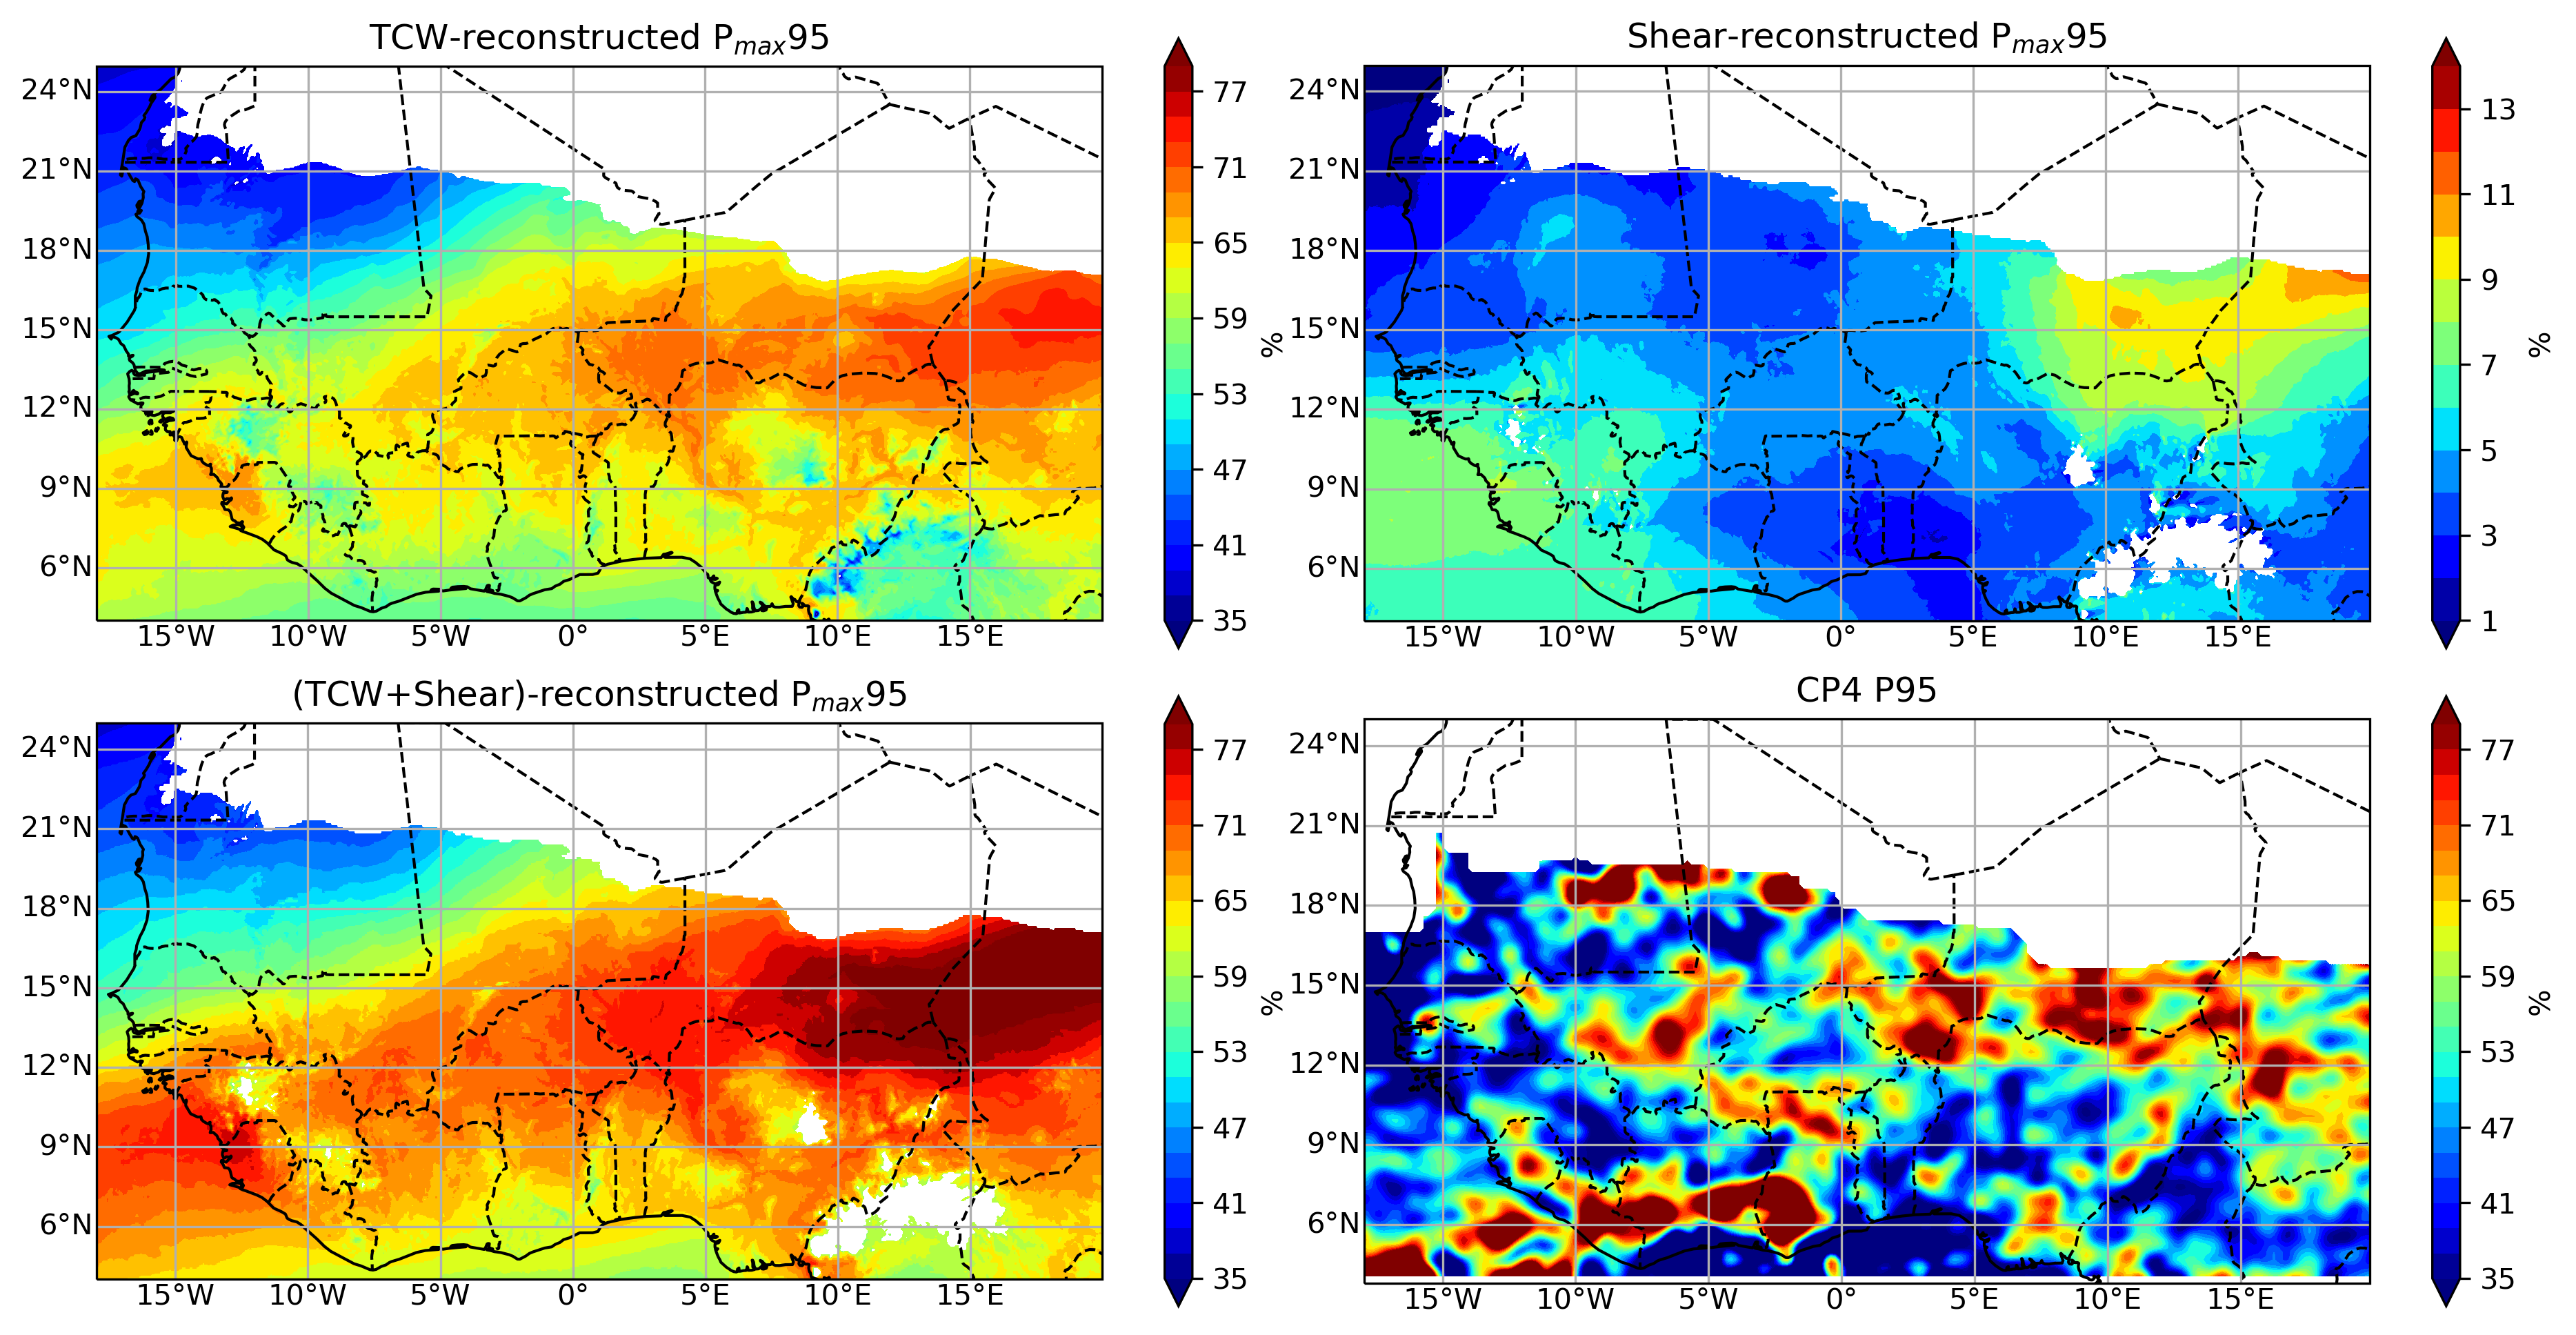

In [49]:
from scipy import ndimage
f = plt.figure(figsize=(12.5,6.5), dpi=300)
tthresh = 24.5   # 0.5th centile
thist_on_precip = fm.salem.lookup_transform(tcw_hist['tcwv'])
thist_on_shear = shear_diff.salem.transform(tcw_hist['tcwv'])
tdiff_on_shear = shear_diff.salem.transform(tcw_diff)

#ndimage.gaussian_filter(((dic2['lsta0']) / (dic2['cnt0'])), 2, mode='nearest')

ax2 = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax2, tcw_diff.where(tcw_hist['tcwv']>tthresh)*tcabsfac/mmPerPercent, tcw_diff.latitude, tcw_diff.longitude, title='TCW-reconstructed P$_{max}$95', levels=np.arange(35,81,2), label=r'%')
ax3 = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax3, (shear_diff.where(thist_on_shear>tthresh)*shearfac)/mmPerPercent, shear_diff.latitude, shear_diff.longitude, title='Shear-reconstructed P$_{max}$95', levels=np.arange(1,15,1), label=r'%')
ax3 = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax3, ((shear_diff.where(thist_on_shear>tthresh)*shearfac)+(tdiff_on_shear.where(thist_on_shear>tthresh)*tcabsfac))/mmPerPercent, shear_diff.latitude, shear_diff.longitude, title='(TCW+Shear)-reconstructed P$_{max}$95', levels=np.arange(35,81,2), label=r'%')

ax5 = f.add_subplot(224, projection=ccrs.PlateCarree())
ax5.set_ylim(3.8,25)
draw_map(ax5, ndimage.gaussian_filter(((fm-hm)/hm*100).where(thist_on_precip>tthresh),2, mode='nearest'), fm.latitude, fm.longitude, title='CP4 P95', levels=np.arange(35,81,2), label=r'%')
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_reconstructed_JASrain.jpg')